#   Alberto Sartini's Master's Thesis - Stock Market Forecasting

# Packages Loading

In [1]:
#EDA Libraries
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from tabulate import tabulate


#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from pandas.plotting import register_matplotlib_converters


In [2]:
#Statistical Libraries
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from scipy.stats import kurtosis, skew
from scipy.stats import ttest_rel
import itertools

In [3]:
# Sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error , mean_absolute_percentage_error
# Parameter Grid
from sklearn.model_selection import ParameterGrid
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# SVR
from sklearn.svm import SVR

In [4]:
#Reti Neurali
from tensorflow.python.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras import layers, models
import random
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Pre-Processing and EDA

In [5]:
# File reading
df=pd.read_excel('shiller_data.xlsx')

# Setting Date as Index
df.set_index('Date', inplace=True)
df.head()

S&P 500  Dividends  Earnings       CPI  10Y Usa Rate
Date                                                            
1900-01-31     6.10     0.2175      0.48  7.897091      3.150000
1900-02-28     6.21     0.2250      0.48  7.992232      3.145833
1900-03-31     6.26     0.2325      0.48  7.992232      3.141667
1900-04-30     6.34     0.2400      0.48  7.992232      3.137500
1900-05-31     6.04     0.2475      0.48  7.801942      3.133333

In [6]:
#Dropping Dividends e CPI columns
df=df.drop(['Dividends' ,'CPI'],axis=1)
df.dropna()

S&P 500    Earnings  10Y Usa Rate
Date                                             
1900-01-31     6.100000    0.480000      3.150000
1900-02-28     6.210000    0.480000      3.145833
1900-03-31     6.260000    0.480000      3.141667
1900-04-30     6.340000    0.480000      3.137500
1900-05-31     6.040000    0.480000      3.133333
...                 ...         ...           ...
2023-08-31  4457.358696  183.170000      4.170000
2023-09-30  4409.095000  184.250000      4.380000
2023-10-31  4269.400909  186.976667      4.800000
2023-11-30  4460.063333  189.703333      4.500000
2023-12-31  4685.051500  192.430000      4.020000

[1488 rows x 3 columns]

In [7]:
# Data selection (from 1945-01-31 onwards)
#first_date = '1945-01-31'
#df = df[df.index >= first_date]
#df.head()

In [8]:
df.columns = df.columns.str.replace("&", "")

In [9]:
df.isnull().any()

SP 500          False
Earnings        False
10Y Usa Rate    False
dtype: bool

In [10]:
df.describe()

SP 500     Earnings  10Y Usa Rate
count  1488.000000  1488.000000   1488.000000
mean    472.175163    22.296074      4.613366
std     892.596230    38.653884      2.511407
min       4.770000     0.290000      0.620000
25%      10.537500     0.958575      2.870000
50%      65.250000     3.541665      3.930000
75%     435.332500    21.687500      5.650000
max    4685.051500   197.910000     15.320000

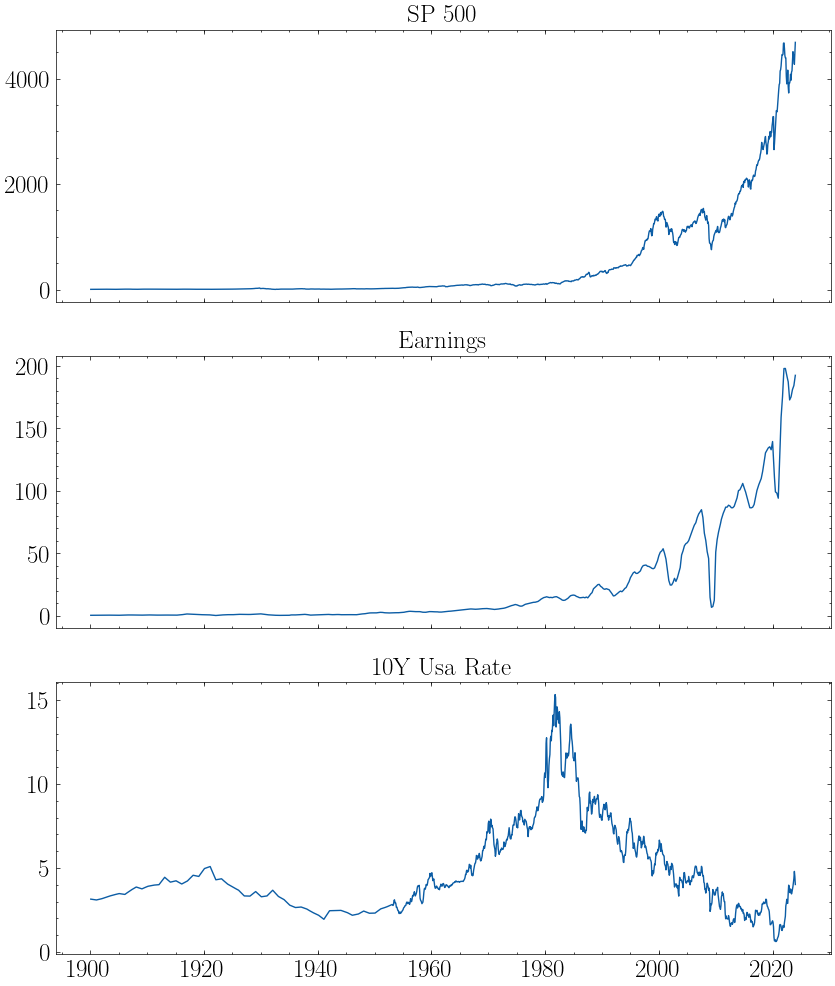

In [11]:
# Plot of the time series in nominal value
with plt.style.context('science'):
    num_vars = len(df.columns)
    fig, axes = plt.subplots(num_vars, 1, figsize=(10, 4 * num_vars), sharex=True)

    for i, col in enumerate(df.columns):
        axes[i].plot(df.index, df[col])
        
        # Imposta titolo e dimensione dei caratteri
        axes[i].set_title(df[col].name, fontsize=18)
        axes[i].tick_params(axis='both', labelsize=18)  # Dimensione dei caratteri degli assi
        axes[i].grid(False)
    #plt.savefig('grafici/serie_in_valore_nominale.svg', format='svg')
    plt.show()


In [12]:
# ADF test to check the stationarity of the time series in nominal value

for i, col in enumerate(df.columns):
    adf_result = adfuller(df[col])
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    used_lags = adf_result[2]
    nobs = adf_result[3]
    critical_values = adf_result[4]
    icbest = adf_result[5]
    
    
    print(f'Results of ADF Test on Residuals for {col}:')
    print(f'ADF Statistic for {col}: {adf_statistic}')
    print(f'p-value for {col} : {p_value}')
    print(f'Number of lags used for {col} : {used_lags}')
    print(f'Number of observations used for {col} : {nobs}')
    print('')
    
# All three series are found to be non-stationary

Results of ADF Test on Residuals for SP 500:
ADF Statistic for SP 500: 6.287974979114241
p-value for SP 500 : 1.0
Number of lags used for SP 500 : 24
Number of observations used for SP 500 : 1463

Results of ADF Test on Residuals for Earnings:
ADF Statistic for Earnings: 4.658318518379777
p-value for Earnings : 1.0
Number of lags used for Earnings : 24
Number of observations used for Earnings : 1463

Results of ADF Test on Residuals for 10Y Usa Rate:
ADF Statistic for 10Y Usa Rate: -1.5928781197576536
p-value for 10Y Usa Rate : 0.4871700815108081
Number of lags used for 10Y Usa Rate : 22
Number of observations used for 10Y Usa Rate : 1465



In [13]:
# Transformation of the dataset into log-levels
df_log = np.log(df)
df_log.columns = ['l_' + col for col in df.columns]

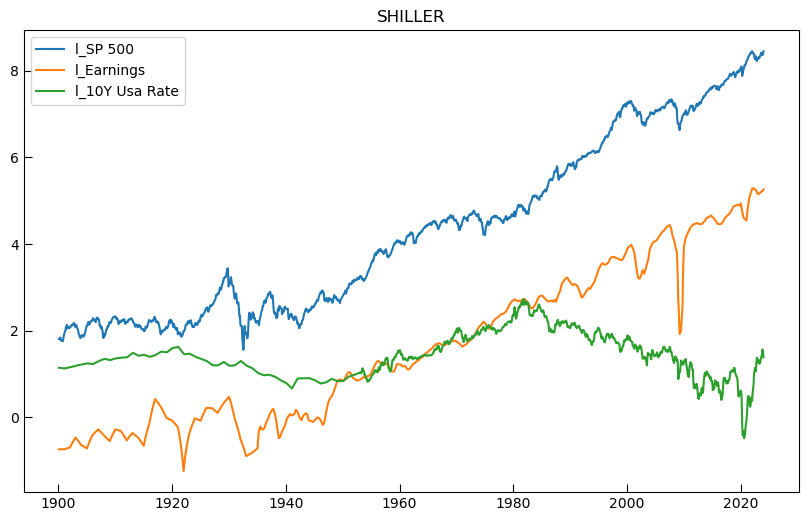

In [14]:
# Plot representing all three series in log-levels
plt.figure(figsize=(10, 6))

for column in df_log.columns:
    plt.plot(df_log.index, df_log[column], label=column)
    
plt.title('SHILLER')
plt.legend()
plt.grid(False)
plt.tick_params(axis='x', which='both', bottom=True, top=False, direction='in', length=6)  
plt.tick_params(axis='y', which='both', left=True, right=False, direction='in', length=6)  
plt.show()


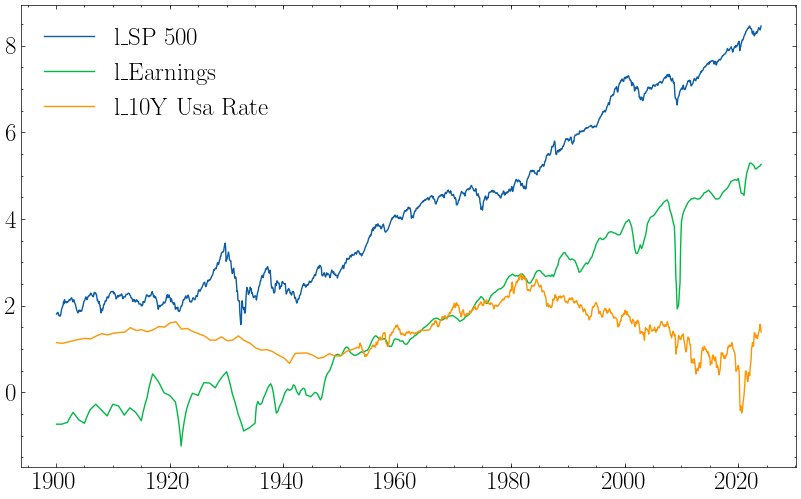

In [15]:
# Plot representing all three series in log-levels
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))

    for column in df_log.columns:
        plt.plot(df_log.index, df_log[column], label=column)

    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)  
    plt.grid(False)
    #plt.savefig('grafici/serie_in_log-livelli.svg', format='svg')
    plt.show()


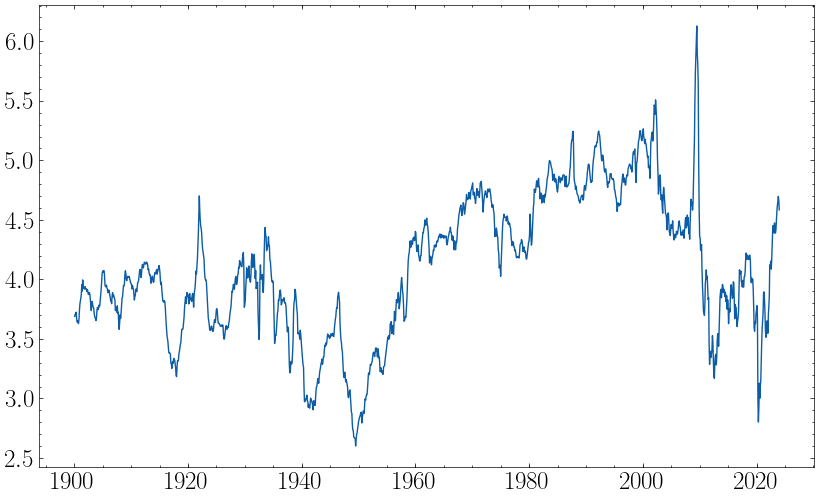

In [16]:
# Plot related to the Ziemba et al. indicator "I"

i_df = df_log['l_10Y Usa Rate']-df_log['l_Earnings']+df_log['l_SP 500']

with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    plt.plot(df_log.index,i_df, label='I')
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    #plt.savefig('grafici/logarithmic_indicator.svg', format='svg')

    plt.show()

In [17]:
i_df =i_df.to_frame(name='indicator')
i_df.head()

indicator
Date                 
1900-01-31   3.689660
1900-02-28   3.706209
1900-03-31   3.712903
1900-04-30   3.724274
1900-05-31   3.674471

In [18]:
# ADF test for "I"

adf_result = adfuller(i_df['indicator'])
adf_statistic = adf_result[0]
p_value = adf_result[1]
used_lags = adf_result[2]
nobs = adf_result[3]
critical_values = adf_result[4]
icbest = adf_result[5]

print(f'Results of ADF Test on Residuals for indicator:')
print(f'ADF Statistic for indicator: {adf_statistic}')
print(f'p-value for indicator: {p_value}')
print(f'Number of lags used for indicator: {used_lags}')
print(f'Number of observations used for indicator: {nobs}')


Results of ADF Test on Residuals for indicator:
ADF Statistic for indicator: -2.50351890150453
p-value for indicator: 0.1146204840345511
Number of lags used for indicator: 24
Number of observations used for indicator: 1463


# Function Definition

## ADF Test Function


In [19]:
def adf_test(residuals_step1):
    
    result = adfuller(residuals_step1)
    return{
        'ADF Statistic:': result[0],
        'p-value:': result[1],
        'Critical Values:':result[4]}

## VAR Lag Selection Function


In [20]:
def var_lag_selection(l_px):
    
    # Creation of the VAR model
    l_px = l_px.asfreq('ME')
    model = VAR(l_px)

    # Using the 'select_order' function to determine the optimal lag
    lag_order = model.select_order(maxlags=15)

    # Find the optimal lag for each criterion
    aic_lag = lag_order.aic
    bic_lag = lag_order.bic
    hqic_lag = lag_order.hqic
    fpe_lag = lag_order.fpe

    # Trova il minimo tra questi lag
    min_lag = min(aic_lag, bic_lag, hqic_lag, fpe_lag)

    return min_lag

## Residual Normality Function (Jarque-Bera Test)

In [21]:
def jb_test(residuals):
    
    result=sms.jarque_bera(residuals)
    return {
        'jb statistic:': result[0],
        'p-value:': result[1],
        'skew:':result[2],
        'kurtosis:':result[3]}

## Series to Lagged Function

In [22]:
def series_to_lagged(d_l_px, lag_ecm, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		d_l_px: Sequence of observations as a dataframe.
		lag_ecm: Number of lags.
		
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""	
	n_vars=d_l_px.shape[1] # number of variables
	cols, names = list(), list()

	# input sequence (t-1, ... t-n)
	for i in range(1, lag_ecm + 1):
		cols.append(d_l_px.shift(i))
		names += [(d_l_px.columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
		
	# merges all the columns into a single dataframe
	agg = concat(cols, axis=1) # axis=1 means that the columns will be concatenated horizontally
	agg.columns = names
 
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True) 
	return agg

## Forecast_Regressor_Construction Function

In [23]:
def forecast_regressors_construction(d_l_px, lag_ecm, residuals_Step1):
    
    regressors_list = []
    n_vars = len(d_l_px.columns)

    # Add the values of the last 'lag_ecm' rows to regressors_list
    for i in range(1, lag_ecm + 1):
        for j in range(n_vars):
            regressors_list.append(d_l_px.iloc[-i, j])
    
    # Add last value of residuals_step1
    regressors_list.append(residuals_Step1.iloc[-1])

    # Converts list into NumPy array
    regressors = np.array(regressors_list)
    # 1: the resulting array will have only one row
    #-1: the resulting array will have as many columns as there are elements in the original array
    regressors = regressors.reshape(1, -1)
                                
    return regressors

## 2-Steps Engle_Granger Function

In [24]:
def f_engle_granger(p,x,rolling_date):
    
    # Assigning the initial values (including rolling_date)
    p = p.loc[:rolling_date]
    x = x.loc[:rolling_date]
    
    # Transforming p and x into log(p) and log(x)
    l_p = np.log(p)
    l_x = np.log(x)
    
    # Join beetween l_p and l_x
    l_px = l_p.join(l_x, how='inner')
    
    # Trasformation in diff_log
    d_l_p = l_p.diff().dropna()
    d_l_x = l_x.diff().dropna()

    # Percentage transformation of d_l_p and d_l_X and removal of non-percentage variables
    d_l_p["SP 500_100"] = d_l_p["SP 500"] * 100
    d_l_p.drop("SP 500", axis=1, inplace=True)

    d_l_x["Earnings_100"] = d_l_x["Earnings"] * 100
    d_l_x.drop("Earnings", axis=1, inplace=True)
    
    d_l_x["10Y Usa Rate_100"] = d_l_x["10Y Usa Rate"] * 100
    d_l_x.drop("10Y Usa Rate", axis=1, inplace=True)
    
    # Join beetween d_l_p and d_l_X
    d_l_px= d_l_p.join(d_l_x, how='inner')
    d_l_px = d_l_px.dropna()
    
    # Step 1  
    l_x_train=l_x
    l_y_train=l_p

    # Adding the constant
    l_x_train = sm.add_constant(l_x_train) 
    
    # Create the regression model on the training data
    model_step1 = sm.OLS(l_y_train, l_x_train).fit()
    residuals_step1 = model_step1.resid
    
    # Call the adf_test function
    adf_output=adf_test(residuals_step1)
    coefficients_step1 = model_step1.params 
    
    
    # Lagging of residuals
    residuals_step1_lagged = residuals_step1.shift(1)
    residuals_step1_lagged.dropna(inplace=True)
        
    #Call Var lag selection function
    min_lag = var_lag_selection(l_px)
  
    # Compute lag_ecm 
    lag_ecm = min_lag - 1
    
    # Call From Series to lagged function
    df_ecm = series_to_lagged(d_l_px,  lag_ecm,  dropnan=True)
    
    # Create a column "eps(t-1)" containing lagged residuals_step1 and add it to df_ecm
    residuals_step1_lagged.name = "eps(t-1)"
    df_ecm = df_ecm.join(residuals_step1_lagged, how='inner')
    
    # Perform an inner join between d_l_p and df_ecm to remove rows from d_l_p 
    # that do not have a match with rows in df_ecm
    df_ecm = df_ecm.join(d_l_p, how='inner') 

    # Step 2
    
    # Reassign the column 'SP 500_100' to d_l_p
    d_l_p_aligned = df_ecm['SP 500_100']   
    d_l_p_aligned = pd.DataFrame(d_l_p_aligned)
    # Remove the 'SP 500_100' column from df_ecm
    df_ecm = df_ecm.drop(columns=["SP 500_100"])
    #X = df_ecm 
    #y = d_l_p_aligned
    
    # Creation of training datasets for step 2
    d_l_x_train_step2 = df_ecm
    d_l_y_train_step2 = d_l_p_aligned
    d_l_x_train_step2 = sm.add_constant(d_l_x_train_step2)
    # Creation of the linear regression model for step 2
    model_step2 = sm.OLS(d_l_y_train_step2, d_l_x_train_step2).fit()
    residuals_step2 = model_step2.resid
    coefficients_step2 = model_step2.params
    
    # Calculate the predictions on the training data
    x_combined_engle_granger = d_l_x_train_step2
    y_combined_engle_granger = d_l_y_train_step2
    y_combined_engle_granger = y_combined_engle_granger.to_numpy().flatten()
    
    y_pred_combined_engle_granger = model_step2.predict(x_combined_engle_granger)
    n = len(d_l_y_train_step2)  # number of observations
    k = len(coefficients_step2)   # number of parameters
    
    # Calculate the likelihood
    residuals = residuals_step2
    sigma_squared = np.var(residuals)  # residuals variance
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals**2) / (2 * sigma_squared)
    
    # Training R2
    engle_granger_training_num = np.inner(y_pred_combined_engle_granger,y_pred_combined_engle_granger)
    engle_granger_training_den = np.inner(y_combined_engle_granger,y_combined_engle_granger)
    r2_training_engle_granger = engle_granger_training_num / engle_granger_training_den
    
    # Training RMSE
    rmse_training_engle_granger = np.sqrt(np.mean((y_combined_engle_granger - y_pred_combined_engle_granger) ** 2))

    std_dev_residuals_step2 = np.std(residuals_step2, ddof = k) #ddof deve esssere pari al numero di parametri udilizzati per fare la regrressione
    rsquared_step2 = model_step2.rsquared
    
    # Call Forecast_Regressors_Construction Function
    ecm_regressors = forecast_regressors_construction(d_l_px, lag_ecm, residuals_step1)
    # Adding costant
    ecm_regressors = sm.add_constant(ecm_regressors, has_constant='add')
    
    # Calculate predictions using model_step2
    forecast_engle_granger = model_step2.predict(ecm_regressors)
    forecast_engle_granger = forecast_engle_granger.item()

    # Calculate confidence intervals
    lower_bound_engle_granger = forecast_engle_granger - 2.33 * std_dev_residuals_step2
    upper_bound_engle_granger = forecast_engle_granger + 2.33 * std_dev_residuals_step2
    
    
    risultati = {
        'forecast_engle_granger': forecast_engle_granger,
        'best_engle_granger_model': coefficients_step2,
        'n_observation_engle_granger' : n,
        'n_params_engle_granger': k,
        'log_likelihood' : log_likelihood,
        'r2_training_engle_granger': r2_training_engle_granger,
        'std_dev_residuals_engle_granger':std_dev_residuals_step2, 
        'rmse_training_engle_granger' : rmse_training_engle_granger,
        'lower_bound_engle_granger': lower_bound_engle_granger,
        'upper_bound_engle_granger': upper_bound_engle_granger,
        'rsquared_step2' : rsquared_step2,
        'residuals_step1': residuals_step1,
        'adf_output':adf_output['p-value:'],
        'd_l_px':d_l_px,
        'd_l_p_aligned': d_l_p_aligned,
        'df_ecm': df_ecm,
        'd_l_x_train_step2': d_l_x_train_step2,
        'lag_ecm': lag_ecm,
        'coefficients_step2' : coefficients_step2,
        'residuals_step2' : residuals_step2,
        'coefficients_of_eps(t-1)_step2':coefficients_step2['eps(t-1)'],
        }
    
    return risultati


## BIC Function

In [25]:
def calculate_bic(n, k, log_likelihood):
    bic =  -2 * log_likelihood + k * np.log(n)
    return  bic

## AIC Function

In [26]:
def calculate_aic(n, k, log_likelihood):
    aic = -2 * log_likelihood + 2 * k
    return aic

## ensemble_learning_weighted_rmse function

In [27]:
def ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf, forecast_svr, forecast_ann, rmse_training_engle_granger, rmse_training_rf, rmse_training_svr, rmse_training_ann):
    inv_rmse_engle_granger = 1 / rmse_training_engle_granger
    inv_rmse_rf = 1 / rmse_training_rf
    inv_rmse_svr = 1 / rmse_training_svr
    inv_rmse_ann = 1 / rmse_training_ann
    total_inv_rmse = inv_rmse_engle_granger + inv_rmse_rf + inv_rmse_svr + inv_rmse_ann
    rmse_training_weight_engle_granger = inv_rmse_engle_granger / total_inv_rmse
    rmse_training_weight_rf = inv_rmse_rf / total_inv_rmse
    rmse_training_weight_svr = inv_rmse_svr / total_inv_rmse
    rmse_training_weight_ann = inv_rmse_ann / total_inv_rmse
    forecast_ensemble_learning_weighted_rmse = (
        rmse_training_weight_engle_granger * forecast_engle_granger +
        rmse_training_weight_rf * forecast_rf +
        rmse_training_weight_svr * forecast_svr +
        rmse_training_weight_ann * forecast_ann
    )
    
    
    return {"forecast_ensemble_learning_weighted_rmse": forecast_ensemble_learning_weighted_rmse,
            "rmse_training_weight_engle_granger": rmse_training_weight_engle_granger,
            "rmse_training_weight_rf": rmse_training_weight_rf,
            "rmse_training_weight_svr": rmse_training_weight_svr,
            "rmse_training_weight_ann": rmse_training_weight_ann}
    

## Building weights  Function 

In [28]:
def building_weights(ic_engle_granger, ic_rf, ic_svr, ic_ann, best_monthly_ic):
    
    # IC differences
    delta_engle_granger = ic_engle_granger - best_monthly_ic
    delta_rf = ic_rf - best_monthly_ic
    delta_svr = ic_svr - best_monthly_ic
    delta_ann = ic_ann - best_monthly_ic
    
    # Normalizing IC differences
    delta_max = max(delta_engle_granger, delta_rf, delta_svr, delta_ann)
    delta_engle_granger_norm = (delta_max - delta_engle_granger) / delta_max
    delta_rf_norm = (delta_max - delta_rf) / delta_max
    delta_svr_norm = (delta_max - delta_svr) / delta_max
    delta_ann_norm = (delta_max - delta_ann) / delta_max
    
    # Final weights
    weight_engle_granger = ((delta_engle_granger_norm)**2) / ((delta_rf_norm)**2 + (delta_svr_norm)**2 + (delta_ann_norm)**2)
    weight_rf = ((delta_rf_norm)**2) / ((delta_rf_norm)**2 + (delta_svr_norm)**2 + (delta_ann_norm)**2)
    weight_svr = ((delta_svr_norm)**2) / ((delta_rf_norm)**2 + (delta_svr_norm)**2 + (delta_ann_norm)**2)
    weight_ann = ((delta_ann_norm)**2) / ((delta_rf_norm)**2 + (delta_svr_norm)**2 + (delta_ann_norm)**2)
    
    return{ 
        'weight_engle_granger': weight_engle_granger,
        'weight_rf': weight_rf,
        'weight_svr': weight_svr,   
        'weight_ann': weight_ann
        }


##  Monthly Best Model Function

In [29]:
def monthly_best_model(best_monthly_ic, ic_engle_granger, ic_rf, ic_svr, 
                       best_engle_granger_model, best_rf_model, best_svr_model,  best_ann_params,  
                       forecast_engle_granger, forecast_random_forest, forecast_svr, forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf, std_dev_residuals_svr, std_dev_residuals_ann):
    
    if best_monthly_ic == ic_engle_granger:
        best_model_name = 'engle_granger'
        best_model_params = best_engle_granger_model
        best_forecast = forecast_engle_granger
        best_std_dev_residuals = std_dev_residuals_engle_granger  
        
    elif best_monthly_ic == ic_rf:
        best_model_name = 'random_forest'
        best_model_params = best_rf_model
        best_forecast = forecast_random_forest
        best_std_dev_residuals = std_dev_residuals_rf  

        
    elif best_monthly_ic == ic_svr:
        best_model_name = 'svr'
        best_model_params = best_svr_model
        best_forecast = forecast_svr
        best_std_dev_residuals = std_dev_residuals_svr
    else:
        best_model_name = 'ann'
        best_model_params = best_ann_params
        best_forecast = forecast_ann
        best_std_dev_residuals = std_dev_residuals_ann
    
    return {
        'best_monthly_ic': best_monthly_ic,
        'best_model_name': best_model_name,
        'best_model_params': best_model_params,
        'best_forecast': best_forecast,
        'best_std_dev_residuals' : best_std_dev_residuals,
    }

##  Monthly Weighted Average Function

In [30]:
def monthly_weighted_average(model_list, return_sp_500):
    
    # Sort models based on weights in descending order
    model_list_sorted = sorted(model_list, key=lambda x: x['weight'], reverse=True)

    # Cumulative sum of weights and selection of the best models
    cumulative_weight = 0
    average_forecast_num = 0
    average_std_dev_residuals_num = 0
    selected_models = []
        
    for model_info in model_list_sorted:
        cumulative_weight += model_info['weight']
        
        average_forecast_num += model_info['weight'] * model_info['forecast']
        average_std_dev_residuals_num += model_info['weight'] * model_info['std_dev_residuals']
        
        average_forecast_den = cumulative_weight
        average_std_dev_residuals_den = cumulative_weight
        selected_models.append(model_info)
        
        # Stop the loop when the cumulative sum exceeds 0.95
        if cumulative_weight >= 0.95:
            break
        
    average_forecast = average_forecast_num / average_forecast_den
    average_std_dev_residuals = average_std_dev_residuals_num / average_std_dev_residuals_den

    return {
        'selected_models': selected_models,
        'total_weight': cumulative_weight,
        'return_sp500': return_sp_500,
        'average_forecast': average_forecast,
        'average_std_dev_residuals' : average_std_dev_residuals
    }


##  Random Forest Function

In [31]:
def f_random_forest(df_ecm, d_l_p_aligned, random_seed=42):
    
    # Set the seed to ensure reproducibility of the results
    np.random.seed(random_seed)
    
    # Assign the features (x_rf) and target variable (y_rf) from the input DataFrames
    x_rf = df_ecm
    y_rf = d_l_p_aligned
    
    # Split the dataset into training set (70%) and validation set (30%)
    split_index = int(len(x_rf) * 0.7)
    
    x_train_rf = x_rf.iloc[:split_index]
    x_validation_rf = x_rf.iloc[split_index:]

    y_train_rf = y_rf.iloc[:split_index]
    y_validation_rf = y_rf.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_rf = y_train_rf.to_numpy().ravel()
    y_validation_rf = y_validation_rf.to_numpy().ravel()
    
    # Initialize the RandomForestRegressor model with a fixed random seed for reproducibility
    rf = RandomForestRegressor(random_state=random_seed)

    # Define the parameters selected from the Professor's article
    param_grid = {
        'n_estimators': [300],
        #'max_features': ['sqrt'],
        'max_depth': [1, 2, 3, 4, 5, 6],
        #'min_samples_split': [2, 5],
        #'min_samples_leaf': [1, 2],
        'bootstrap': [True]
    }
    
    # Initialize best parameters and minimum error
    best_params = None
    best_error = float('inf')  # Set the initial minimum error to infinity

    # Grid Search
    # Perform Grid Search on Training Set and Validation Set
    for params in ParameterGrid(param_grid):
        rf.set_params(**params)
        rf.fit(x_train_rf, y_train_rf)
        y_pred = rf.predict(x_validation_rf)
        error = root_mean_squared_error(y_validation_rf, y_pred)
        # If the current error is lower than the previous one (best_error), update the best parameters
        if error < best_error:
            best_error = error
            best_params = params
    
    rmse_validation_rf = best_error
    # Combine the training set and validation set to retrain the final model with the best parameters
    x_combined_rf = pd.concat([x_train_rf, x_validation_rf])
    y_combined_rf = np.concatenate([y_train_rf, y_validation_rf])

    # Create a new RandomForestRegressor model with the best parameters found
    best_rf_model = RandomForestRegressor(**best_params)
    # Train the final model with the combined dataset (training + validation)
    best_rf_model.fit(x_combined_rf, y_combined_rf)
    # Calculate predictions on the combined data
    y_pred_combined_rf = best_rf_model.predict(x_combined_rf)
    
    n = len(y_combined_rf)  # number of observations
    k = len(best_params)  # number of parameters 
     
    # Calculate log likelihood
    residuals_rf = y_combined_rf - y_pred_combined_rf
    sigma_squared = np.var(residuals_rf)  # Variance of residuals
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_rf**2) / (2 * sigma_squared)

    # Training R2
    rf_training_num = np.inner(y_pred_combined_rf, y_pred_combined_rf)
    rf_training_den = np.inner(y_combined_rf, y_combined_rf)
    r2_training_rf = rf_training_num / rf_training_den

    # Training RMSE
    rmse_training_rf = np.sqrt(np.mean((y_combined_rf - y_pred_combined_rf) ** 2))
    
    #Standard deviation of residuals
    std_dev_residuals_rf = np.std(residuals_rf, ddof = k)
    
    

    return {
        'best_rf_model': best_rf_model,
        'n_observation_rf': n,
        'n_params_rf': k,
        'log_likelihood': log_likelihood,
        'r2_training_rf': r2_training_rf,
        'rmse_validation_rf': rmse_validation_rf,     
        'rmse_training_rf': rmse_training_rf, 
        'std_dev_residuals_rf' : std_dev_residuals_rf
        #'best_params': best_grid,
        #'best_error': best_error,
    }


## SVR Function

In [32]:
def f_svr(df_ecm, d_l_p_aligned):
    
    # Assign features (x_svr) and target variable (y_svr) from the input DataFrames
    x_svr = df_ecm
    y_svr = d_l_p_aligned
    
    # Split the dataset into training set and validation set
    split_index = int(len(x_svr) * 0.7)
    
    x_train_svr = x_svr.iloc[:split_index]
    x_validation_svr = x_svr.iloc[split_index:]

    y_train_svr = y_svr.iloc[:split_index]
    y_validation_svr = y_svr.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_svr = y_train_svr.to_numpy().ravel()
    y_validation_svr = y_validation_svr.to_numpy().ravel()

    # Initialize the SVR model
    model_svr = SVR()

    # Define the parameters selected from the Professor's article
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'poly'],
        'epsilon': [0.01, 0.1, 0.5],
        'degree': [2, 3],
        'gamma': ['scale']
    }
    
    # Initialize best parameters and minimum error
    best_params = None
    best_error = float('inf')

    # Grid Search
    
    # Perform Grid Search on Train Set and Validation Set
    for params in ParameterGrid(param_grid):
        model_svr.set_params(**params)
        model_svr.fit(x_train_svr, y_train_svr)
        y_pred = model_svr.predict(x_validation_svr)
        error = root_mean_squared_error(y_validation_svr, y_pred)
        
        # If the current error is lower than the previous one (best_error), update the best parameters    
        if error < best_error:
            best_error = error
            best_params = params
    
    rmse_validation_svr = best_error
    # Create combined datasets
    x_combined_svr = pd.concat([x_train_svr, x_validation_svr])
    y_combined_svr = np.concatenate([y_train_svr, y_validation_svr])

    # Create a new SVR model with the best parameters found
    best_svr_model = SVR(**best_params)
    # Train the final model with the combined dataset (training + validation)
    best_svr_model.fit(x_combined_svr, y_combined_svr)
    # Calculate predictions on the combined data
    y_pred_combined_svr = best_svr_model.predict(x_combined_svr)
    
    # Calculate the BIC
    n = len(y_combined_svr)  # number of observations
    k = len(best_params)  # number of parameters (including intercept)
    
    # Calculate log likelihood
    residuals_svr = y_combined_svr - y_pred_combined_svr
    sigma_squared = np.var(residuals_svr)  # Variance of residuals_svr
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_svr**2) / (2 * sigma_squared)
        
    # Training R2
    svr_training_num = np.inner(y_pred_combined_svr, y_pred_combined_svr)
    svr_training_den = np.inner(y_combined_svr, y_combined_svr)
    r2_training_svr = svr_training_num / svr_training_den
    
    # Training RMSE
    rmse_training_svr = np.sqrt(np.mean((y_combined_svr - y_pred_combined_svr) ** 2))
    
    #Standard deviation of residuals_svr
    std_dev_residuals_svr = np.std(residuals_svr, ddof = k)

    return {
        'best_svr_model': best_svr_model,
        'n_observation_svr': n,
        'n_params_svr': k,     
        'log_likelihood': log_likelihood,   
        'r2_training_svr': r2_training_svr,
        'rmse_validation_svr': rmse_validation_svr,
        'rmse_training_svr': rmse_training_svr,
        'std_dev_residuals_svr': std_dev_residuals_svr
        #'best_params': best_grid,
        #'best_error': best_error,
    }


## ANN Functions

In [33]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

In [34]:

def create_ann_model(activation='relu', neurons=[32,16] ,  input_shape=None ,learning_rate=0.01): #epochs=100 e learning rate=0.01 potrebbero essere eliminati  da  qui in teoria perchè vengono richiamati in f_ann
    model = models.Sequential()
    
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(units =neurons[0], activation=activation))
    model.add(layers.Dense(units = neurons[1], activation=activation))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



In [35]:

def f_ann(df_ecm, d_l_p_aligned, random_seed = 42):
    
    # Set the seed to ensure reproducibility
    set_seed(random_seed)
    
    # Assign features (x_ann) and target variable (y_ann) from the input DataFrames
    x_ann = df_ecm
    y_ann = d_l_p_aligned
    
    # Split the dataset into training set and validation set
    split_index = int(len(x_ann) * 0.7)
    
    x_train_ann = x_ann.iloc[:split_index]
    x_validation_ann = x_ann.iloc[split_index:]

    y_train_ann = y_ann.iloc[:split_index]
    y_validation_ann = y_ann.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_ann = y_train_ann.to_numpy().ravel()
    y_validation_ann = y_validation_ann.to_numpy().ravel()
    
    # Grid search parameters
    param_grid = {
        'activation': ['relu'],
        'input_shape': [x_train_ann.shape[1]],
        'learning_rate': [0.01, 0.1],

    }
    
    # Initialize best error and best parameters
    best_error = float('inf')
    best_ann_params = {}
    
    
    rmse_validation_ann = best_error
    # Manual Grid Search
    # Perform Grid Search on Train Set and Validation Set
    for params in ParameterGrid(param_grid):
        # Create and train the model
        model_ann = create_ann_model(**params)
        model_ann.fit(x_train_ann, y_train_ann, epochs=20, batch_size=x_train_ann.shape[0], 
                      validation_data=(x_validation_ann, y_validation_ann), shuffle=False, verbose=0)
        y_pred = model_ann.predict(x_validation_ann).ravel()
        error = root_mean_squared_error(y_validation_ann, y_pred)
        
        # Update best parameters if the error improves
        if error < best_error:
            best_error = error
            best_ann_params = params
            
    # Create combined datasets
    x_combined_ann = pd.concat([x_train_ann, x_validation_ann])
    y_combined_ann = np.concatenate([y_train_ann, y_validation_ann])

    # Create a new ANN model with the best parameters found
    best_ann_model = create_ann_model(**best_ann_params)
    # Train the final model with the combined dataset (training + validation)
    best_ann_model.fit(x_combined_ann, y_combined_ann, epochs= 50, batch_size=x_combined_ann.shape[0], shuffle=False, verbose=0) 
    # Make predictions on the combined data
    y_pred_combined_ann = best_ann_model.predict(x_combined_ann).ravel()
    
    # Calculate the BIC
    n = len(y_combined_ann)  # number of observations
    k = len(best_ann_params)
    
    # Calculate log likelihood
    residuals_ann = y_combined_ann - y_pred_combined_ann
    sigma_squared = np.var(residuals_ann)  # Variance of residuals_ann
    log_likelihood = - n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_ann**2) / (2 * sigma_squared)


    # Training R2
    ann_training_num = np.inner(y_pred_combined_ann, y_pred_combined_ann)
    ann_training_den = np.inner(y_combined_ann, y_combined_ann)
    r2_training_ann = ann_training_num / ann_training_den
    
    # Training RMSE
    rmse_training_ann = np.sqrt(np.mean((y_combined_ann - y_pred_combined_ann) ** 2))
    
    #Standard deviation of residuals_ann
    std_dev_residuals_ann = np.std(residuals_ann, ddof = k)

    return {
        'best_ann_model': best_ann_model,
        'best_ann_params': best_ann_params,
        'n_observation_ann': n,
        'n_params_ann': k,  
        'log_likelihood': log_likelihood,    
        'rmse_validation_ann': rmse_validation_ann, 
        'r2_training_ann': r2_training_ann,
        'rmse_training_ann': rmse_training_ann,
        'std_dev_residuals_ann' : std_dev_residuals_ann
        #'best_error': best_error,
    }



# Backtest Cycle

In [36]:
# Define the date range
start_backtest_date = pd.to_datetime('2001-01-31')
end_backtest_date = pd.to_datetime('2023-12-31')

# Define P and X
p = df[['SP 500']]
x = df[['Earnings', '10Y Usa Rate']] 

# Create the backtest dataset
df_filtered = df.loc[start_backtest_date:end_backtest_date]

In [37]:
df_filtered.head()

SP 500   Earnings  10Y Usa Rate
Date                                        
2001-01-31  1335.63  48.480000          5.16
2001-02-28  1305.75  46.960000          5.10
2001-03-31  1185.85  45.440000          4.89
2001-04-30  1189.84  42.556667          5.14
2001-05-31  1270.37  39.673333          5.39

In [38]:
# Backtest Cycle

# Lists initialization
date_list=[]
y_true_list = []
sp_500_true_list = []
# Original models
adf_output_list = []
residuals_step1_list = []
rsquared_step2_list = []
coefficients_of_eps_t_1__step2_list = []

forecast_random_walk_list = []
forecast_engle_granger_list = []
forecast_rf_list = []
forecast_svr_list = []
forecast_svr_converted_list = []
forecast_ann_list = []
lower_bound_engle_granger_list = []
upper_bound_engle_granger_list = []
lower_bound_rf_list = []
upper_bound_rf_list = []
lower_bound_svr_list = []
upper_bound_svr_list = []
lower_bound_ann_list = []
upper_bound_ann_list = []

rmse_training_rf_list = []
rmse_training_svr_list = []
rmse_training_ann_list = []

rmse_validation_rf_list = []
rmse_validation_svr_list = []
rmse_validation_ann_list = []

# Weighted models
forecast_ensemble_learning_simple_mean_list = []
forecast_ensemble_learning_weighted_r2_list = []
forecast_ensemble_learning_weighted_rmse_list = []
#
forecast_ensemble_learning_weighted_test_rmse_list = []

lower_bound_ensemble_learning_simple_mean_list =[]
upper_bound_ensemble_learning_simple_mean_list =[]
lower_bound_ensemble_learning_weighted_r2_list =[]
upper_bound_ensemble_learning_weighted_r2_list =[]
lower_bound_ensemble_learning_weighted_rmse_list =[]
upper_bound_ensemble_learning_weighted_rmse_list =[]
#
upper_bound_ensemble_learning_weighted_test_rmse_list = []
lower_bound_ensemble_learning_weighted_test_rmse_list =[]

# Combined Forecast
weight_bic_rf_list = []
weight_bic_svr_list = []
weight_bic_ann_list = []
weight_bic_engle_granger_list = []

weight_aic_rf_list = []
weight_aic_svr_list = []
weight_aic_ann_list = []
weight_aic_engle_granger_list = []

forecast_bic_monthly_best_list = []
forecast_aic_monthly_best_list = []
forecast_bic_monthly_weighted_average_list = []
forecast_aic_monthly_weighted_average_list = []

forecast_bic_monthly_weighted_average_converted_list = []

lower_bound_bic_monthly_best_list = []
upper_bound_bic_monthly_best_list = []
lower_bound_aic_monthly_best_list = []
upper_bound_aic_monthly_best_list = []

lower_bound_bic_weighted_average_list = []
upper_bound_bic_weighted_average_list = []
lower_bound_aic_weighted_average_list = []
upper_bound_aic_weighted_average_list = []

lower_bound_bic_weighted_average_converted_list = []
upper_bound_bic_weighted_average_converted_list = []



# Dictionaries initialization
engle_granger_dict ={}
rf_dict = {}
svr_dict = {}
ann_dict = {}

forecast_bic_best_dict = {}
forecast_bic_weighted_average_dict = {}
forecast_aic_best_dict = {}
forecast_aic_weighted_average_dict = {}

# df_filtered iteration
count = 0
for rolling_date, row in df_filtered.iterrows():
    if rolling_date == pd.Timestamp('2023-12-31'):
        break
    # Get the SP 500 values for the month corresponding to 'rolling_date' from 'df_filtered' (t)
    sp_500_current= df_filtered.loc[rolling_date,'SP 500']
    # Calculate the next month after rolling_date
    next_date = rolling_date + pd.offsets.MonthEnd(1)
    # Get the SP 500 values for the month following 'rolling_date' from 'df_filtered' (t+1)
    sp_500_next = df_filtered.loc[next_date,'SP 500']
    # log-trasformation
    l_sp_500_current = np.log(sp_500_current)
    l_sp_500_next = np.log(sp_500_next)
    # Returns
    return_sp_500 = (l_sp_500_next - l_sp_500_current)*100
    # Lists update
    date_list.append(next_date)
    sp_500_true_list.append(sp_500_next)
    y_true_list.append(return_sp_500)
    
    # Data calling
    output_engle_granger = f_engle_granger(p, x, rolling_date)
    d_l_px = output_engle_granger['d_l_px'] 
    return_sp_500_current = d_l_px["SP 500_100"].iloc[-1]
    std_return_sp_500 = d_l_px["SP 500_100"].std()
    
    # Random walk forecast
    noise = np.random.normal(0, 1)
    forecast_random_walk = return_sp_500_current + std_return_sp_500 * noise
    forecast_random_walk_list.append(forecast_random_walk)
    
    # ENGLE - GRANGER
    forecast_engle_granger = output_engle_granger['forecast_engle_granger']
    #forecast_engle_granger = forecast_engle_granger.item()
    best_engle_granger_model = output_engle_granger['best_engle_granger_model']
    n_observation_engle_granger = output_engle_granger['n_observation_engle_granger']
    n_params_engle_granger = output_engle_granger['n_params_engle_granger']
    log_likelihood_engle_granger = output_engle_granger['log_likelihood']
    std_dev_residuals_engle_granger = output_engle_granger['std_dev_residuals_engle_granger']
    # bic
    bic_engle_granger = calculate_bic(n_observation_engle_granger, n_params_engle_granger, log_likelihood_engle_granger)
    # aic
    aic_engle_granger = calculate_aic(n_observation_engle_granger, n_params_engle_granger, log_likelihood_engle_granger)
    
    # Engle-Granger's lists update
    adf_output_list.append(output_engle_granger['adf_output'])
    residuals_step1_list.append(output_engle_granger['residuals_step1'])
    rsquared_step2_list.append(output_engle_granger['rsquared_step2'])
    coefficients_of_eps_t_1__step2_list.append(output_engle_granger['coefficients_of_eps(t-1)_step2'])
    forecast_engle_granger_list.append(forecast_engle_granger)
    lower_bound_engle_granger_list.append(output_engle_granger['lower_bound_engle_granger'])
    upper_bound_engle_granger_list.append(output_engle_granger['upper_bound_engle_granger'])

    
    
    # RANDOM FOREST
    output_rf = f_random_forest(output_engle_granger['df_ecm'],output_engle_granger['d_l_p_aligned'])
    regressors_rf = forecast_regressors_construction(output_engle_granger['d_l_px'],output_engle_granger['lag_ecm'], output_engle_granger['residuals_step1'])
    forecast_rf = output_rf['best_rf_model'].predict(regressors_rf)
    forecast_rf = forecast_rf.item()
    best_rf_model = output_rf['best_rf_model']
    n_observation_rf = output_rf['n_observation_rf']
    n_params_rf = output_rf['n_params_rf']
    log_likelihood_rf = output_rf['log_likelihood']
    std_dev_residuals_rf = output_rf['std_dev_residuals_rf']
    rmse_training_rf = output_rf['rmse_training_rf']
    rmse_validation_rf = output_rf['rmse_validation_rf']
    
    # bic
    bic_rf = calculate_bic(n_observation_rf, n_params_rf, log_likelihood_rf)
    # aic
    aic_rf = calculate_aic(n_observation_rf, n_params_rf, log_likelihood_rf)
    # Confindence interval 99%
    lower_bound_rf = forecast_rf - 2.33 * std_dev_residuals_rf
    upper_bound_rf = forecast_rf + 2.33 * std_dev_residuals_rf
    # Random forest lists update
    forecast_rf_list.append(forecast_rf)
    lower_bound_rf_list.append(lower_bound_rf)
    upper_bound_rf_list.append(upper_bound_rf)
    rmse_training_rf_list.append(rmse_training_rf)
    rmse_validation_rf_list.append(rmse_validation_rf)

    
    # SVR
    output_svr = f_svr(output_engle_granger['df_ecm'],output_engle_granger['d_l_p_aligned'])
    svr_regressors = forecast_regressors_construction(output_engle_granger['d_l_px'],output_engle_granger['lag_ecm'], output_engle_granger['residuals_step1'])
    forecast_svr = output_svr['best_svr_model'].predict(svr_regressors)
    forecast_svr = forecast_svr.item()
    best_svr_model = output_svr['best_svr_model']
    n_observation_svr = output_svr['n_observation_svr']
    n_params_svr = output_svr['n_params_svr']
    log_likelihood_svr = output_svr['log_likelihood']
    std_dev_residuals_svr = output_svr['std_dev_residuals_svr']
    rmse_training_svr = output_svr['rmse_training_svr']
    rmse_validation_svr = output_svr['rmse_validation_svr']
    
    # bic
    bic_svr = calculate_bic(n_observation_svr, n_params_svr, log_likelihood_svr)
    # aic
    aic_svr = calculate_aic(n_observation_svr, n_params_svr, log_likelihood_svr)
    # Confindence interval 99%
    lower_bound_svr = forecast_svr - 2.33 * std_dev_residuals_svr
    upper_bound_svr = forecast_svr + 2.33 * std_dev_residuals_svr    
    # SVR lists update
    forecast_svr_list.append(forecast_svr)
    lower_bound_svr_list.append(lower_bound_svr)
    upper_bound_svr_list.append(upper_bound_svr)
    rmse_training_svr_list.append(rmse_training_svr)
    rmse_validation_svr_list.append(rmse_validation_svr)
    
    # Conversion from "d_l_P" to "P"
    forecast_svr_converted = sp_500_current * np.exp(forecast_svr/100)
    
    std_dev_residuals_svr_converted = forecast_svr_converted * (std_dev_residuals_svr/100)
    lower_bound_svr_converted = forecast_svr_converted - 2.33 * std_dev_residuals_svr_converted
    upper_bound_svr_converted = forecast_svr_converted + 2.33 * std_dev_residuals_svr_converted
    
    forecast_svr_converted_list.append(forecast_svr_converted)
    #std_dev_residuals_svr_converted_list.append(std_dev_residuals_svr_converted)
    #lower_bound_svr_converted_list.append(lower_bound_svr_converted)
    #upper_bound_svr_converted_list.append(upper_bound_svr_converted)
    
    
        
    # ANN
    output_ann = f_ann(output_engle_granger['df_ecm'],output_engle_granger['d_l_p_aligned'])
    ann_regressors = forecast_regressors_construction(output_engle_granger['d_l_px'],output_engle_granger['lag_ecm'], output_engle_granger['residuals_step1'])
    forecast_ann = output_ann['best_ann_model'].predict(ann_regressors)
    forecast_ann = forecast_ann.item()
    best_ann_model = output_ann['best_ann_model']
    best_ann_params = output_ann['best_ann_params']
    n_observation_ann = output_ann['n_observation_ann']
    n_params_ann = output_ann['n_params_ann']
    log_likelihood_ann = output_ann['log_likelihood']
    std_dev_residuals_ann = output_ann['std_dev_residuals_ann']
    rmse_training_ann = output_ann['rmse_training_ann']
    rmse_validation_ann = output_ann['rmse_validation_ann']
    
    # bic
    bic_ann = calculate_bic(n_observation_ann, n_params_ann, log_likelihood_ann)
    # aic
    aic_ann = calculate_aic(n_observation_ann, n_params_ann, log_likelihood_ann)
    # Confindence interval 99%
    lower_bound_ann = forecast_ann - 2.33 * std_dev_residuals_ann
    upper_bound_ann = forecast_ann + 2.33 * std_dev_residuals_ann
    # ANN lists update
    forecast_ann_list.append(forecast_ann)
    lower_bound_ann_list.append(lower_bound_ann)
    upper_bound_ann_list.append(upper_bound_ann)
    rmse_training_ann_list.append(rmse_training_ann)
    rmse_validation_ann_list.append(rmse_validation_ann)
    
    # ENSEMBLE LEARNING SIMPLE MEAN
    forecast_ensemble_learning_simple_mean = (forecast_engle_granger + forecast_rf + forecast_svr + forecast_ann) / 4
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_simple_mean = (std_dev_residuals_engle_granger + std_dev_residuals_rf + std_dev_residuals_svr + std_dev_residuals_ann) / 4   
    lower_bound_ensemble_learning_simple_mean = forecast_ensemble_learning_simple_mean - 2.33 * std_dev_residuals_ensemble_learning_simple_mean
    upper_bound_ensemble_learning_simple_mean = forecast_ensemble_learning_simple_mean + 2.33 * std_dev_residuals_ensemble_learning_simple_mean
    # Ensemble learning simple mean lists update
    forecast_ensemble_learning_simple_mean_list.append(forecast_ensemble_learning_simple_mean)
    lower_bound_ensemble_learning_simple_mean_list.append(lower_bound_ensemble_learning_simple_mean)
    upper_bound_ensemble_learning_simple_mean_list.append(upper_bound_ensemble_learning_simple_mean)
    
    # ENSEMBLE LEARNING WEIGHTED R2 MEAN
    r2_training_engle_granger = output_engle_granger['r2_training_engle_granger']
    r2_training_rf = output_rf['r2_training_rf']
    r2_training_svr = output_svr['r2_training_svr']
    r2_training_ann = output_ann['r2_training_ann']
    total_r2_training = r2_training_engle_granger + r2_training_rf + r2_training_svr + r2_training_ann
    r2_training_weight_engle_granger = r2_training_engle_granger / total_r2_training
    r2_training_weight_rf = r2_training_rf / total_r2_training
    r2_training_weight_svr = r2_training_svr / total_r2_training
    r2_training_weight_ann = r2_training_ann / total_r2_training
    forecast_ensemble_learning_weighted_r2 = r2_training_weight_engle_granger*forecast_engle_granger + r2_training_weight_rf*forecast_rf + r2_training_weight_svr*forecast_svr + r2_training_weight_ann*forecast_ann
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_weighted_r2 = r2_training_weight_engle_granger*std_dev_residuals_engle_granger + r2_training_weight_rf*std_dev_residuals_rf + r2_training_weight_svr*std_dev_residuals_svr + r2_training_weight_ann*std_dev_residuals_ann
    lower_bound_ensemble_learning_weighted_r2 = forecast_ensemble_learning_weighted_r2 - 2.33 * std_dev_residuals_ensemble_learning_weighted_r2
    upper_bound_ensemble_learning_weighted_r2 = forecast_ensemble_learning_weighted_r2 + 2.33 * std_dev_residuals_ensemble_learning_weighted_r2
    # Ensemble learning weighted R2 mean list update
    forecast_ensemble_learning_weighted_r2_list.append(forecast_ensemble_learning_weighted_r2)
    lower_bound_ensemble_learning_weighted_r2_list.append(lower_bound_ensemble_learning_weighted_r2)
    upper_bound_ensemble_learning_weighted_r2_list.append(upper_bound_ensemble_learning_weighted_r2)    

      
    
    # ENSEMBLE LEARNING WEIGHTED RMSE MEAN
    rmse_training_engle_granger = output_engle_granger['rmse_training_engle_granger']
    rmse_training_rf = output_rf['rmse_training_rf']
    rmse_training_svr = output_svr['rmse_training_svr']
    rmse_training_ann = output_ann['rmse_training_ann']
    rmse_training_engle_granger = output_engle_granger['rmse_training_engle_granger']
    output_ensemble_learning_weighted_rmse = ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf, forecast_svr, forecast_ann, rmse_training_engle_granger, rmse_training_rf, rmse_training_svr, rmse_training_ann)
    forecast_ensemble_learning_weighted_rmse = output_ensemble_learning_weighted_rmse['forecast_ensemble_learning_weighted_rmse']
    rmse_training_weight_engle_granger = output_ensemble_learning_weighted_rmse['rmse_training_weight_engle_granger']
    rmse_training_weight_rf = output_ensemble_learning_weighted_rmse['rmse_training_weight_rf']
    rmse_training_weight_svr = output_ensemble_learning_weighted_rmse['rmse_training_weight_svr']
    rmse_training_weight_ann = output_ensemble_learning_weighted_rmse['rmse_training_weight_ann']
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_weighted_rmse = rmse_training_weight_engle_granger * std_dev_residuals_engle_granger + rmse_training_weight_rf * std_dev_residuals_rf + rmse_training_weight_svr * std_dev_residuals_svr + rmse_training_weight_ann*std_dev_residuals_ann
    lower_bound_ensemble_learning_weighted_rmse = forecast_ensemble_learning_weighted_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_rmse
    upper_bound_ensemble_learning_weighted_rmse = forecast_ensemble_learning_weighted_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_rmse
    #Ensemble learning weighted RMSE mean
    forecast_ensemble_learning_weighted_rmse_list.append(forecast_ensemble_learning_weighted_rmse)
    lower_bound_ensemble_learning_weighted_rmse_list.append(lower_bound_ensemble_learning_weighted_rmse)
    upper_bound_ensemble_learning_weighted_rmse_list.append(upper_bound_ensemble_learning_weighted_rmse)    
     
    # ENSEMBLE LEARNING WEIGHTED TEST RMSE
    # At the first iteration of the backtest cycle no weights are given to the forecasts 
    if rolling_date == df_filtered.index[0]:
        forecast_ensemble_learning_weighted_test_rmse = (forecast_engle_granger + forecast_rf + forecast_svr + forecast_ann) / 4
        # Confindence interval 99%
        std_dev_residuals_ensemble_learning_weighted_test_rmse = (std_dev_residuals_engle_granger +  std_dev_residuals_rf + std_dev_residuals_svr + std_dev_residuals_ann) / 4
        lower_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
        upper_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
    else:
        # Calcolo degli RMSE per ogni modello (dalla seconda iterazione in poi)
        rmse_test_engle_granger = root_mean_squared_error(y_true_list, forecast_engle_granger_list)
        rmse_test_rf = root_mean_squared_error(y_true_list, forecast_rf_list)
        rmse_test_svr = root_mean_squared_error(y_true_list, forecast_svr_list)
        rmse_test_ann = root_mean_squared_error(y_true_list, forecast_ann_list)
        # Calcolo dei pesi e dei forecast  per ogni modello (dalla seconda iterazione in poi)
        output_ensemble_learning_weighted_test_rmse = ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf, forecast_svr, forecast_ann, rmse_test_engle_granger, rmse_test_rf, rmse_test_svr, rmse_test_ann)
        forecast_ensemble_learning_weighted_test_rmse = output_ensemble_learning_weighted_test_rmse['forecast_ensemble_learning_weighted_rmse']
        test_rmse_weight_engle_granger = output_ensemble_learning_weighted_rmse['rmse_training_weight_engle_granger']
        test_rmse_weight_rf = output_ensemble_learning_weighted_rmse['rmse_training_weight_rf']
        test_rmse_weight_svr = output_ensemble_learning_weighted_rmse['rmse_training_weight_svr']
        test_rmse_weight_ann = output_ensemble_learning_weighted_rmse['rmse_training_weight_ann']
        # Confindence interval 99%
        std_dev_residuals_ensemble_learning_weighted_test_rmse = test_rmse_weight_engle_granger * std_dev_residuals_engle_granger + test_rmse_weight_rf * std_dev_residuals_rf + test_rmse_weight_svr * std_dev_residuals_svr + test_rmse_weight_ann*std_dev_residuals_ann
        lower_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
        upper_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
    # Ensemble learning weighted TEST RMSE mean list update
    forecast_ensemble_learning_weighted_test_rmse_list.append(forecast_ensemble_learning_weighted_test_rmse)
    upper_bound_ensemble_learning_weighted_test_rmse_list.append(upper_bound_ensemble_learning_weighted_test_rmse)
    lower_bound_ensemble_learning_weighted_test_rmse_list.append(lower_bound_ensemble_learning_weighted_test_rmse)

    
    # ENSEMBLE LEARNING GIANFREDA SCANDOLO
    best_monthly_bic = min(bic_engle_granger, bic_rf, bic_svr, bic_ann) 
    best_monthly_aic = min(aic_engle_granger, aic_rf, aic_svr, aic_ann) 

    # Building weights
    # BIC weights
    weights_bic = building_weights(bic_engle_granger, bic_rf, bic_svr, bic_ann, best_monthly_bic)
        
    weight_bic_engle_granger = weights_bic['weight_engle_granger']
    weight_bic_engle_granger_list.append(weight_bic_engle_granger)
    
    weight_bic_rf = weights_bic['weight_rf']
    weight_bic_rf_list.append(weight_bic_rf)
    
    weight_bic_svr = weights_bic['weight_svr']
    weight_bic_svr_list.append(weight_bic_svr)
    
    weight_bic_ann = weights_bic['weight_ann']
    weight_bic_ann_list.append(weight_bic_ann)

    # AIC weights
    weights_aic = building_weights(aic_engle_granger, aic_rf, aic_svr, aic_ann, best_monthly_aic)
        
    weight_aic_engle_granger = weights_aic['weight_engle_granger']
    weight_aic_engle_granger_list.append(weight_aic_engle_granger)
    
    weight_aic_rf = weights_aic['weight_rf']
    weight_aic_rf_list.append(weight_aic_rf)
    
    weight_aic_svr = weights_aic['weight_svr']
    weight_aic_svr_list.append(weight_aic_svr)
    
    weight_aic_ann = weights_aic['weight_ann']
    weight_aic_ann_list.append(weight_aic_ann)

    # Dictionaries update
    engle_granger_dict[next_date] = {
        'model_name' : 'engle_granger',
        'best_engle_granger_model_params' : best_engle_granger_model,
        'return_sp_500' : return_sp_500,
        'forecast_engle_granger': forecast_engle_granger,
        'std_dev_residuals_engle_granger':std_dev_residuals_engle_granger,
        'bic_engle_granger' :bic_engle_granger,
        'weight_bic_engle_granger':weight_bic_engle_granger,
        'aic_engle_granger' :aic_engle_granger,
        'weight_aic_engle_granger':weight_aic_engle_granger,        
        }
    
    rf_dict[next_date] = {
        'model_name' : 'random_forest',
        'best_rf_model_params' : best_rf_model,
        'return_sp_500' : return_sp_500,
        'forecast_rf': forecast_rf,
        'std_dev_residuals_rf':std_dev_residuals_rf,
        'bic_rf' :bic_rf,
        'weight_bic_rf':weight_bic_rf,
        'aic_rf' :aic_rf,
        'weight_aic_rf':weight_aic_rf,        
        }
    
    svr_dict[next_date] = {
        'model_name' : 'svr',
        'best_svr_model_params' : best_svr_model,        
        'return_sp_500' : return_sp_500,
        'forecast_svr': forecast_svr,
        'std_dev_residuals_svr':std_dev_residuals_svr,
        'bic_svr' :bic_svr,
        'weight_bic_svr' : weight_bic_svr,
        'aic_svr' :aic_svr,
        'weight_aic_svr' : weight_aic_svr
        }
    
    ann_dict[next_date] = {
        'model_name' : 'ann',
        'best_ann_model_params' : best_ann_params,    
        'return_sp_500' : return_sp_500,
        'forecast_ann':  forecast_ann,
        'std_dev_residuals_ann':std_dev_residuals_ann,
        'bic_ann' : bic_ann,
        'weight_bic_ann' : weight_bic_ann,
        'aic_ann' : aic_ann,
        'weight_aic_ann' : weight_aic_ann,        
        }
    
    
    # Identifying the monthly best model for each information critherion
    output_monthly_best_model_bic = monthly_best_model(best_monthly_bic, bic_engle_granger, bic_rf,  bic_svr, 
                       best_engle_granger_model,best_rf_model, best_svr_model,  best_ann_params,  
                       forecast_engle_granger,forecast_rf, forecast_svr,  forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf, std_dev_residuals_svr, std_dev_residuals_ann
        )
    
    forecast_bic_best_dict[next_date] = output_monthly_best_model_bic
    
    output_monthly_best_model_aic = monthly_best_model(best_monthly_aic, aic_engle_granger,aic_rf,  aic_svr, 
                       best_engle_granger_model, best_rf_model, best_svr_model, best_ann_params,  
                       forecast_engle_granger, forecast_rf, forecast_svr,  forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf, std_dev_residuals_svr, std_dev_residuals_ann
        )

    forecast_aic_best_dict[next_date] = output_monthly_best_model_aic
    
    # Extract the best monthly forecasts for each information criterion
    forecast_bic_monthly_best = forecast_bic_best_dict[next_date]['best_forecast']
    forecast_aic_monthly_best = forecast_aic_best_dict[next_date]['best_forecast']

    # Confindence interval 99%
    std_dev_residuals_bic_monthly_best = forecast_bic_best_dict[next_date]['best_std_dev_residuals']
    std_dev_residuals_aic_monthly_best = forecast_aic_best_dict[next_date]['best_std_dev_residuals']
    
    lower_bound_bic_monthly_best = forecast_bic_monthly_best - 2.33 * std_dev_residuals_bic_monthly_best
    upper_bound_bic_monthly_best = forecast_bic_monthly_best + 2.33 * std_dev_residuals_bic_monthly_best
    lower_bound_aic_monthly_best = forecast_aic_monthly_best - 2.33 * std_dev_residuals_aic_monthly_best
    upper_bound_aic_monthly_best = forecast_aic_monthly_best + 2.33 * std_dev_residuals_aic_monthly_best
    
    
    
    # monthly best model for each information critherion lists update
    forecast_bic_monthly_best_list.append(forecast_bic_monthly_best) 
    forecast_aic_monthly_best_list.append(forecast_aic_monthly_best)
    lower_bound_bic_monthly_best_list.append(lower_bound_bic_monthly_best)
    upper_bound_bic_monthly_best_list.append(upper_bound_bic_monthly_best)
    lower_bound_aic_monthly_best_list.append(lower_bound_aic_monthly_best)
    upper_bound_aic_monthly_best_list.append(upper_bound_aic_monthly_best)  
     


    #Identifying the set of plausible models "P"
    model_list_bic = [
        {'model_name': 'engle_granger', 'model_params': best_engle_granger_model, 'forecast': forecast_engle_granger, 'std_dev_residuals': std_dev_residuals_engle_granger, 'weight': weight_bic_engle_granger },
        {'model_name': 'random_forest', 'model_params': best_rf_model, 'forecast': forecast_rf, 'std_dev_residuals':std_dev_residuals_rf, 'weight': weight_bic_rf},
        {'model_name': 'svr', 'model_params': best_svr_model, 'forecast': forecast_svr,'std_dev_residuals':std_dev_residuals_svr, 'weight': weight_bic_svr},
        {'model_name': 'ann', 'model_params': best_ann_params, 'forecast': forecast_ann,'std_dev_residuals':std_dev_residuals_ann, 'weight': weight_bic_ann}]
    
    model_list_aic = [
        {'model_name': 'engle_granger', 'model_params': best_engle_granger_model, 'forecast': forecast_engle_granger, 'std_dev_residuals': std_dev_residuals_engle_granger, 'weight': weight_aic_engle_granger },        
        {'model_name': 'random_forest', 'model_params': best_rf_model, 'forecast': forecast_rf, 'std_dev_residuals': std_dev_residuals_rf, 'weight': weight_aic_rf},
        {'model_name': 'svr', 'model_params': best_svr_model, 'forecast': forecast_svr,'std_dev_residuals': std_dev_residuals_svr, 'weight': weight_aic_svr},
        {'model_name': 'ann', 'model_params': best_ann_params, 'forecast': forecast_ann, 'std_dev_residuals': std_dev_residuals_ann, 'weight': weight_aic_ann}]
     
    # Add the information to the forecast_ic_average_dict dictionary
    output_weighted_average_bic = monthly_weighted_average(model_list_bic, return_sp_500)
    forecast_bic_weighted_average_dict[next_date] = output_weighted_average_bic
    
    output_weighted_average_aic = monthly_weighted_average(model_list_aic, return_sp_500)
    forecast_aic_weighted_average_dict[next_date] = output_weighted_average_aic
    
    # Extract the combination monthly forecasts for each information criterion
    forecast_bic_weighted_average = forecast_bic_weighted_average_dict[next_date]['average_forecast']
    forecast_aic_weighted_average = forecast_aic_weighted_average_dict[next_date]['average_forecast']
    
    # Confindence interval 99%
    std_dev_residuals_bic_weighted_average = forecast_bic_weighted_average_dict[next_date]['average_std_dev_residuals']
    std_dev_residuals_aic_weighted_average= forecast_aic_weighted_average_dict[next_date]['average_std_dev_residuals']
    
    lower_bound_bic_weighted_average = forecast_bic_weighted_average - 2.33 * std_dev_residuals_bic_weighted_average
    upper_bound_bic_weighted_average = forecast_bic_weighted_average + 2.33 * std_dev_residuals_bic_weighted_average
    lower_bound_aic_weighted_average = forecast_aic_weighted_average - 2.33 * std_dev_residuals_aic_weighted_average
    upper_bound_aic_weighted_average = forecast_aic_weighted_average + 2.33 * std_dev_residuals_aic_weighted_average
    
    # Conversion from "d_l_P" to "P"
    
    forecast_bic_weighted_average_converted = sp_500_current * np.exp(forecast_bic_weighted_average / 100)
    
    std_dev_residuals_bic_weighted_average_converted = forecast_bic_weighted_average_converted * (std_dev_residuals_bic_weighted_average / 100)
    lower_bound_bic_weighted_average_converted = forecast_bic_weighted_average_converted - 2.33 * std_dev_residuals_bic_weighted_average_converted
    upper_bound_bic_weighted_average_converted = forecast_bic_weighted_average_converted + 2.33 * std_dev_residuals_bic_weighted_average_converted

    # Monthly weighted average lists update for each information criterion 
    forecast_bic_monthly_weighted_average_list.append(forecast_bic_weighted_average)
    forecast_aic_monthly_weighted_average_list.append(forecast_aic_weighted_average)
    forecast_bic_monthly_weighted_average_converted_list.append(forecast_bic_weighted_average_converted)
    

    lower_bound_bic_weighted_average_list.append(lower_bound_bic_weighted_average)  
    upper_bound_bic_weighted_average_list.append(upper_bound_bic_weighted_average) 
    lower_bound_aic_weighted_average_list.append(lower_bound_aic_weighted_average)  
    upper_bound_aic_weighted_average_list.append(upper_bound_aic_weighted_average)
    lower_bound_bic_weighted_average_converted_list.append(lower_bound_bic_weighted_average_converted)
    upper_bound_bic_weighted_average_converted_list.append(upper_bound_bic_weighted_average_converted)    
    
print(f"Count: {count}")
   
# 671 (mesi) = (2001-1945)*12 

# 947 (mesi) = [(2024-1945)*12]-1

# 276 (mesi) = 2024 -2001


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Count: 0


# Data saving

In [39]:
# Dataframe creation

all_models_forecast_over_time_df = pd.DataFrame({"observed_sp500_returns" : y_true_list,
                                                 "forecast_randomwalk": forecast_random_walk_list,
                                                 "forecast_engle_granger": forecast_engle_granger_list, 
                                                 "lower_bound_engle_granger": lower_bound_engle_granger_list, 
                                                 "upper_bound_engle_granger": upper_bound_engle_granger_list,
                                                 "forecast_rf": forecast_rf_list, 
                                                 "lower_bound_rf": lower_bound_rf_list, 
                                                 "upper_bound_rf": upper_bound_rf_list,
                                                 "forecast_svr": forecast_svr_list, 
                                                 "lower_bound_svr": lower_bound_svr_list,
                                                 "upper_bound_svr": upper_bound_svr_list, 
                                                 "forecast_ann": forecast_ann_list, 
                                                 "lower_bound_ann": lower_bound_ann_list,
                                                 "upper_bound_ann": upper_bound_ann_list,
                                                 "forecast_ensemble_learning_simple_mean": forecast_ensemble_learning_simple_mean_list,
                                                 "lower_bound_ensemble_learning_simple_mean": lower_bound_ensemble_learning_simple_mean_list,
                                                 "upper_bound_ensemble_learning_simple_mean": upper_bound_ensemble_learning_simple_mean_list,
                                                 "forecast_ensemble_learning_weighted_r2": forecast_ensemble_learning_weighted_r2_list,
                                                 "lower_bound_ensemble_learning_weighted_r2": lower_bound_ensemble_learning_weighted_r2_list,
                                                 "upper_bound_ensemble_learning_weighted_r2": upper_bound_ensemble_learning_weighted_r2_list,
                                                 "forecast_ensemble_learning_weighted_rmse": forecast_ensemble_learning_weighted_rmse_list,
                                                 "lower_bound_ensemble_learning_weighted_rmse": lower_bound_ensemble_learning_weighted_rmse_list,
                                                 "upper_bound_ensemble_learning_weighted_rmse": upper_bound_ensemble_learning_weighted_rmse_list,
                                                 "forecast_ensemble_learning_weighted_test_rmse": forecast_ensemble_learning_weighted_test_rmse_list,
                                                 "lower_bound_ensemble_learning_weighted_test_rmse": lower_bound_ensemble_learning_weighted_test_rmse_list,
                                                 "upper_bound_ensemble_learning_weighted_test_rmse": upper_bound_ensemble_learning_weighted_test_rmse_list,
                                                 "rmse_training_rf": rmse_training_rf_list,
                                                 "rmse_training_svr": rmse_training_svr_list,
                                                 "rmse_training_ann": rmse_training_ann_list,
                                                 "rmse_validation_rf": rmse_validation_rf_list,
                                                 "rmse_validation_svr": rmse_validation_svr_list,
                                                 "rmse_validation_ann": rmse_validation_ann_list,
                                                
                                                 "forecast_bic_monthly_best": forecast_bic_monthly_best_list,
                                                 "lower_bound_bic_monthly_best": lower_bound_bic_monthly_best_list,
                                                 "upper_bound_bic_monthly_best": upper_bound_bic_monthly_best_list,
                                                
                                                 "forecast_aic_monthly_best": forecast_aic_monthly_best_list,
                                                 "lower_bound_aic_monthly_best": lower_bound_aic_monthly_best_list,
                                                 "upper_bound_aic_monthly_best": upper_bound_aic_monthly_best_list,
                                                 
                                                 "forecast_bic_monthly_weighted_average": forecast_bic_monthly_weighted_average_list,
                                                 "lower_bound_bic_weighted_average": lower_bound_bic_weighted_average_list,
                                                 "upper_bound_bic_weighted_average": upper_bound_bic_weighted_average_list,
                                                 
                                                 "forecast_aic_monthly_weighted_average": forecast_aic_monthly_weighted_average_list,
                                                 "lower_bound_aic_monthly_weighted_average": lower_bound_aic_weighted_average_list,
                                                 "upper_bound_aic_monthly_weighted_average": upper_bound_aic_weighted_average_list, 
                                                 
                                                 "forecast_bic_monthly_weighted_average_converted": forecast_bic_monthly_weighted_average_converted_list,
                                                 "lower_bound_bic_weighted_average_converted": lower_bound_bic_weighted_average_converted_list,
                                                 "upper_bound_bic_weighted_average_converted": upper_bound_bic_weighted_average_converted_list,
                                                 "adf_output": adf_output_list,
                                                # "residuals_step1": residuals_step1_list,
                                                 "rsquared_step2": rsquared_step2_list,
                                                 "coefficients_of_eps_t_1__step2": coefficients_of_eps_t_1__step2_list
                                                                                                 
                                                 }, index = date_list )

#  Combined Forecast (BIC): Weights comparison with return

In [40]:

# Weight comparison with returns
# Model: forecast_bic_weighted_average

# Creiamo una lista di date ordinate
dates = sorted(forecast_bic_weighted_average_dict.keys())
return_sp_500_list = []
models_weights_over_time_dict = {}
all_models_set = set()

# Creo un insieme che contiene il nome dei modelli
for values in forecast_bic_weighted_average_dict.values():
    for model in values['selected_models']:
        all_models_set.add(model['model_name'])

# Creo una chiave "model_name" (all'interno del dizionario weights) e la inizializzo con una lista vuota
for model_name in all_models_set:
    models_weights_over_time_dict[model_name] = []
for timestamp in dates:
    return_sp_500_list.append(forecast_bic_weighted_average_dict[timestamp]['return_sp500'])

    model_weights_dict = {}  # Creiamo un dizionario vuoto per i pesi
    for model in forecast_bic_weighted_average_dict[timestamp]['selected_models']:
        model_name = model['model_name']  # Estraiamo il nome del modello
        model_weight = model['weight']  # Estraiamo il peso del modello
        model_weights_dict[model_name] = model_weight  # Aggiungiamo al dizionario
    
    for model_name in all_models_set:
        models_weights_over_time_dict[model_name].append(model_weights_dict.get(model_name, np.nan))  # Usa NaN se il modello non è presente



In [41]:
# Weights over time in  DataFrame
models_weights_over_time_df = pd.DataFrame(models_weights_over_time_dict, index=dates) 
models_weights_over_time_df["return_sp_500"] = return_sp_500_list


In [42]:
models_weights_over_time_df.head()

random_forest  engle_granger       ann  return_sp_500
2001-02-28            NaN       0.415424  0.734021      -2.262550
2001-03-31            NaN       0.416067  0.733821      -9.631777
2001-04-30            NaN            NaN  0.990366       0.335903
2001-05-31            NaN            NaN  0.989375       6.548935
2001-06-30            NaN       0.415184  0.726047      -2.523768

In [43]:
all_models_forecast_over_time_df.head()

observed_sp500_returns  forecast_randomwalk  \
2001-02-28               -2.262550             4.105133   
2001-03-31               -9.631777            -0.117433   
2001-04-30                0.335903            -7.482740   
2001-05-31                6.548935             2.484055   
2001-06-30               -2.523768             8.697970   

            forecast_engle_granger  lower_bound_engle_granger  \
2001-02-28                0.133504                  -9.483878   
2001-03-31               -0.665220                 -10.279871   
2001-04-30               -2.184651                 -11.813943   
2001-05-31               -1.219197                 -10.845896   
2001-06-30                0.490032                  -9.146447   

            upper_bound_engle_granger  forecast_rf  lower_bound_rf  \
2001-02-28                   9.750887     0.115026       -9.601724   
2001-03-31                   8.949431     0.066192       -9.647695   
2001-04-30                   7.444641    -0.309400      -10.039042   
2001-05-31                   8.407501    -0.001654       -9.727712   
2001-06-30                  10.126511     1.175698       -8.556591   

            upper_bound_rf  forecast_svr  lower_bound_svr  ...  \
2001-02-28        9.831776      0.820825        -9.025113  ...   
2001-03-31        9.780078      0.686346        -9.157843  ...   
2001-04-30        9.420242     -0.055681        -9.701121  ...   
2001-05-31        9.724405      0.502310        -9.139052  ...   
2001-06-30       10.907987      5.251115        -4.613773  ...   

            upper_bound_bic_weighted_average  \
2001-02-28                         10.025803   
2001-03-31                          9.063196   
2001-04-30                          7.525422   
2001-05-31                          8.061207   
2001-06-30                         10.249763   

            forecast_aic_monthly_weighted_average  \
2001-02-28                               0.402226   
2001-03-31                              -0.542582   
2001-04-30                              -2.107615   
2001-05-31                              -1.431459   
2001-06-30                               0.619830   

            lower_bound_aic_monthly_weighted_average  \
2001-02-28                                 -9.195004   
2001-03-31                                -10.137408   
2001-04-30                                -11.714496   
2001-05-31                                -11.035569   
2001-06-30                                 -8.998044   

            upper_bound_aic_monthly_weighted_average  \
2001-02-28                                  9.999455   
2001-03-31                                  9.052244   
2001-04-30                                  7.499267   
2001-05-31                                  8.172652   
2001-06-30                                 10.237705   

            forecast_bic_monthly_weighted_average_converted  \
2001-02-28                                      1341.395084   
2001-03-31                                      1298.854099   
2001-04-30                                      1161.546758   
2001-05-31                                      1171.748408   
2001-06-30                                      1278.448538   

            lower_bound_bic_weighted_average_converted  \
2001-02-28                                 1212.686970   
2001-03-31                                 1174.258743   
2001-04-30                                 1050.082984   
2001-05-31                                 1059.337993   
2001-06-30                                 1155.514757   

            upper_bound_bic_weighted_average_converted  adf_output  \
2001-02-28                                 1470.103198    0.021938   
2001-03-31                                 1423.449455    0.022087   
2001-04-30                                 1273.010533    0.016722   
2001-05-31                                 1284.158823    0.025052   
2001-06-30                                 1401.382318    0.036786   

            rsqua

In [44]:
all_models_forecast_over_time_df.to_csv("all_models_forecast_over_time_df.csv", index=True, encoding="utf-8")
models_weights_over_time_df.to_csv("models_weights_over_time_df.csv", index=True, encoding="utf-8")


# Data loading

In [45]:
all_models_forecast_over_time_df = pd.read_csv("all_models_forecast_over_time_df.csv", index_col=0, parse_dates=True)
models_weights_over_time_df = pd.read_csv("models_weights_over_time_df.csv", index_col=0, parse_dates=True)

In [46]:
all_models_forecast_over_time_df.head()

observed_sp500_returns  forecast_randomwalk  \
2001-02-28               -2.262550             4.105133   
2001-03-31               -9.631777            -0.117433   
2001-04-30                0.335903            -7.482740   
2001-05-31                6.548935             2.484055   
2001-06-30               -2.523768             8.697970   

            forecast_engle_granger  lower_bound_engle_granger  \
2001-02-28                0.133504                  -9.483878   
2001-03-31               -0.665220                 -10.279871   
2001-04-30               -2.184651                 -11.813943   
2001-05-31               -1.219197                 -10.845896   
2001-06-30                0.490032                  -9.146447   

            upper_bound_engle_granger  forecast_rf  lower_bound_rf  \
2001-02-28                   9.750887     0.115026       -9.601724   
2001-03-31                   8.949431     0.066192       -9.647695   
2001-04-30                   7.444641    -0.309400      -10.039042   
2001-05-31                   8.407501    -0.001654       -9.727712   
2001-06-30                  10.126511     1.175698       -8.556591   

            upper_bound_rf  forecast_svr  lower_bound_svr  ...  \
2001-02-28        9.831776      0.820825        -9.025113  ...   
2001-03-31        9.780078      0.686346        -9.157843  ...   
2001-04-30        9.420242     -0.055681        -9.701121  ...   
2001-05-31        9.724405      0.502310        -9.139052  ...   
2001-06-30       10.907987      5.251115        -4.613773  ...   

            upper_bound_bic_weighted_average  \
2001-02-28                         10.025803   
2001-03-31                          9.063196   
2001-04-30                          7.525422   
2001-05-31                          8.061207   
2001-06-30                         10.249763   

            forecast_aic_monthly_weighted_average  \
2001-02-28                               0.402226   
2001-03-31                              -0.542582   
2001-04-30                              -2.107615   
2001-05-31                              -1.431459   
2001-06-30                               0.619830   

            lower_bound_aic_monthly_weighted_average  \
2001-02-28                                 -9.195004   
2001-03-31                                -10.137408   
2001-04-30                                -11.714496   
2001-05-31                                -11.035569   
2001-06-30                                 -8.998044   

            upper_bound_aic_monthly_weighted_average  \
2001-02-28                                  9.999455   
2001-03-31                                  9.052244   
2001-04-30                                  7.499267   
2001-05-31                                  8.172652   
2001-06-30                                 10.237705   

            forecast_bic_monthly_weighted_average_converted  \
2001-02-28                                      1341.395084   
2001-03-31                                      1298.854099   
2001-04-30                                      1161.546758   
2001-05-31                                      1171.748408   
2001-06-30                                      1278.448538   

            lower_bound_bic_weighted_average_converted  \
2001-02-28                                 1212.686970   
2001-03-31                                 1174.258743   
2001-04-30                                 1050.082984   
2001-05-31                                 1059.337993   
2001-06-30                                 1155.514757   

            upper_bound_bic_weighted_average_converted  adf_output  \
2001-02-28                                 1470.103198    0.021938   
2001-03-31                                 1423.449455    0.022087   
2001-04-30                                 1273.010533    0.016722   
2001-05-31                                 1284.158823    0.025052   
2001-06-30                                 1401.382318    0.036786   

            rsqua

In [47]:
models_dict = {"random_walk": {"forecast": all_models_forecast_over_time_df["forecast_randomwalk"],
                               "forecast_residuals": all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_randomwalk"],
                                "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_randomwalk"]) / np.absolute( all_models_forecast_over_time_df["observed_sp500_returns"])},
               
               "engle_granger": {"forecast": all_models_forecast_over_time_df["forecast_engle_granger"],
                                 "forecast_residuals": all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_engle_granger"],
                                 "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_engle_granger"]) / np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"]),
                                 "lower_bound": all_models_forecast_over_time_df["lower_bound_engle_granger"],
                                 "upper_bound": all_models_forecast_over_time_df["upper_bound_engle_granger"]},
               
               "random_forest": {"forecast": all_models_forecast_over_time_df["forecast_rf"],
                                 "forecast_residuals": all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_rf"],
                                    "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_rf"]) / np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"]),
                                 "lower_bound": all_models_forecast_over_time_df["lower_bound_rf"],
                                 "upper_bound": all_models_forecast_over_time_df["upper_bound_rf"]},
               
               #"svr": {"forecast": all_models_forecast_over_time_df["forecast_svr"],
               #       "forecast_residuals": all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_svr"],
               #           "relative_forecast_residuals": (all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_svr"]) / all_models_forecast_over_time_df["observed_sp500_returns"],
               #        "lower_bound": all_models_forecast_over_time_df["lower_bound_svr"],
               #        "upper_bound": all_models_forecast_over_time_df["upper_bound_svr"]},
               
               
               "ann": {"forecast": all_models_forecast_over_time_df["forecast_ann"],
                       "forecast_residuals": all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_ann"],
                          "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_ann"]) / np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"]),
                       "lower_bound": all_models_forecast_over_time_df["lower_bound_ann"],
                       "upper_bound": all_models_forecast_over_time_df["upper_bound_ann"]},
               
               "bic_monthly_weighted_average": {"forecast": all_models_forecast_over_time_df["forecast_bic_monthly_weighted_average"],
                                                "forecast_residuals" : all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_bic_monthly_weighted_average"],
                                                "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"] - all_models_forecast_over_time_df["forecast_bic_monthly_weighted_average"]) / np.absolute(all_models_forecast_over_time_df["observed_sp500_returns"]),
                                                "lower_bound": all_models_forecast_over_time_df["lower_bound_bic_weighted_average"],
                                                "upper_bound": all_models_forecast_over_time_df["upper_bound_bic_weighted_average"]}
                  }

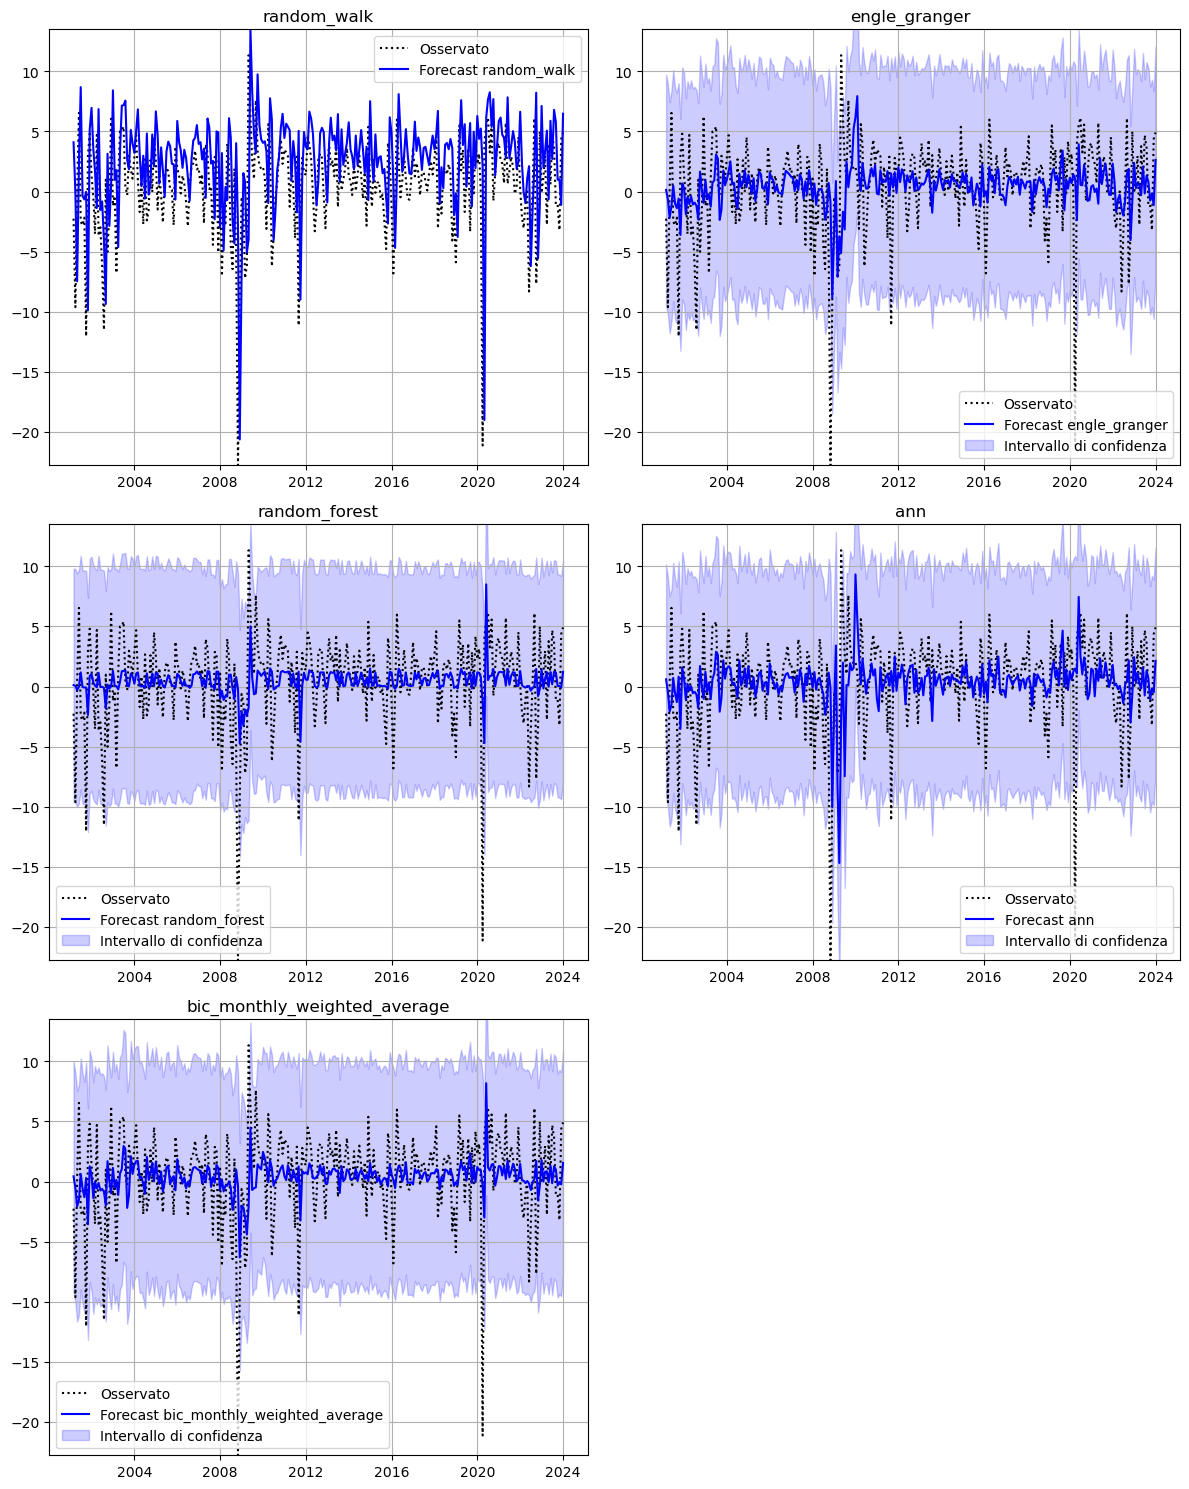

In [48]:
# Supponiamo che all_models_forecast_over_time_df sia già definito
observed_returns = all_models_forecast_over_time_df["observed_sp500_returns"]

# Troviamo i valori minimi e massimi per uniformare gli assi Y
y_min = min(observed_returns.min(), min(data["forecast"].min() for data in models_dict.values()))
y_max = max(observed_returns.max(), max(data["forecast"].max() for data in models_dict.values()))

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):
    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot delle osservazioni
    ax.plot(observed_returns, label="Osservato", color='black', linestyle="dotted")

    # Plot del forecast
    ax.plot(data["forecast"], label=f"Forecast {model_name}", color='blue')

    # Se il modello ha intervalli di confidenza, li aggiungiamo
    if "lower_bound" in data and "upper_bound" in data:
        ax.fill_between(data["forecast"].index, data["lower_bound"], data["upper_bound"], 
                        color='blue', alpha=0.2, label="Intervallo di confidenza")

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)

# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


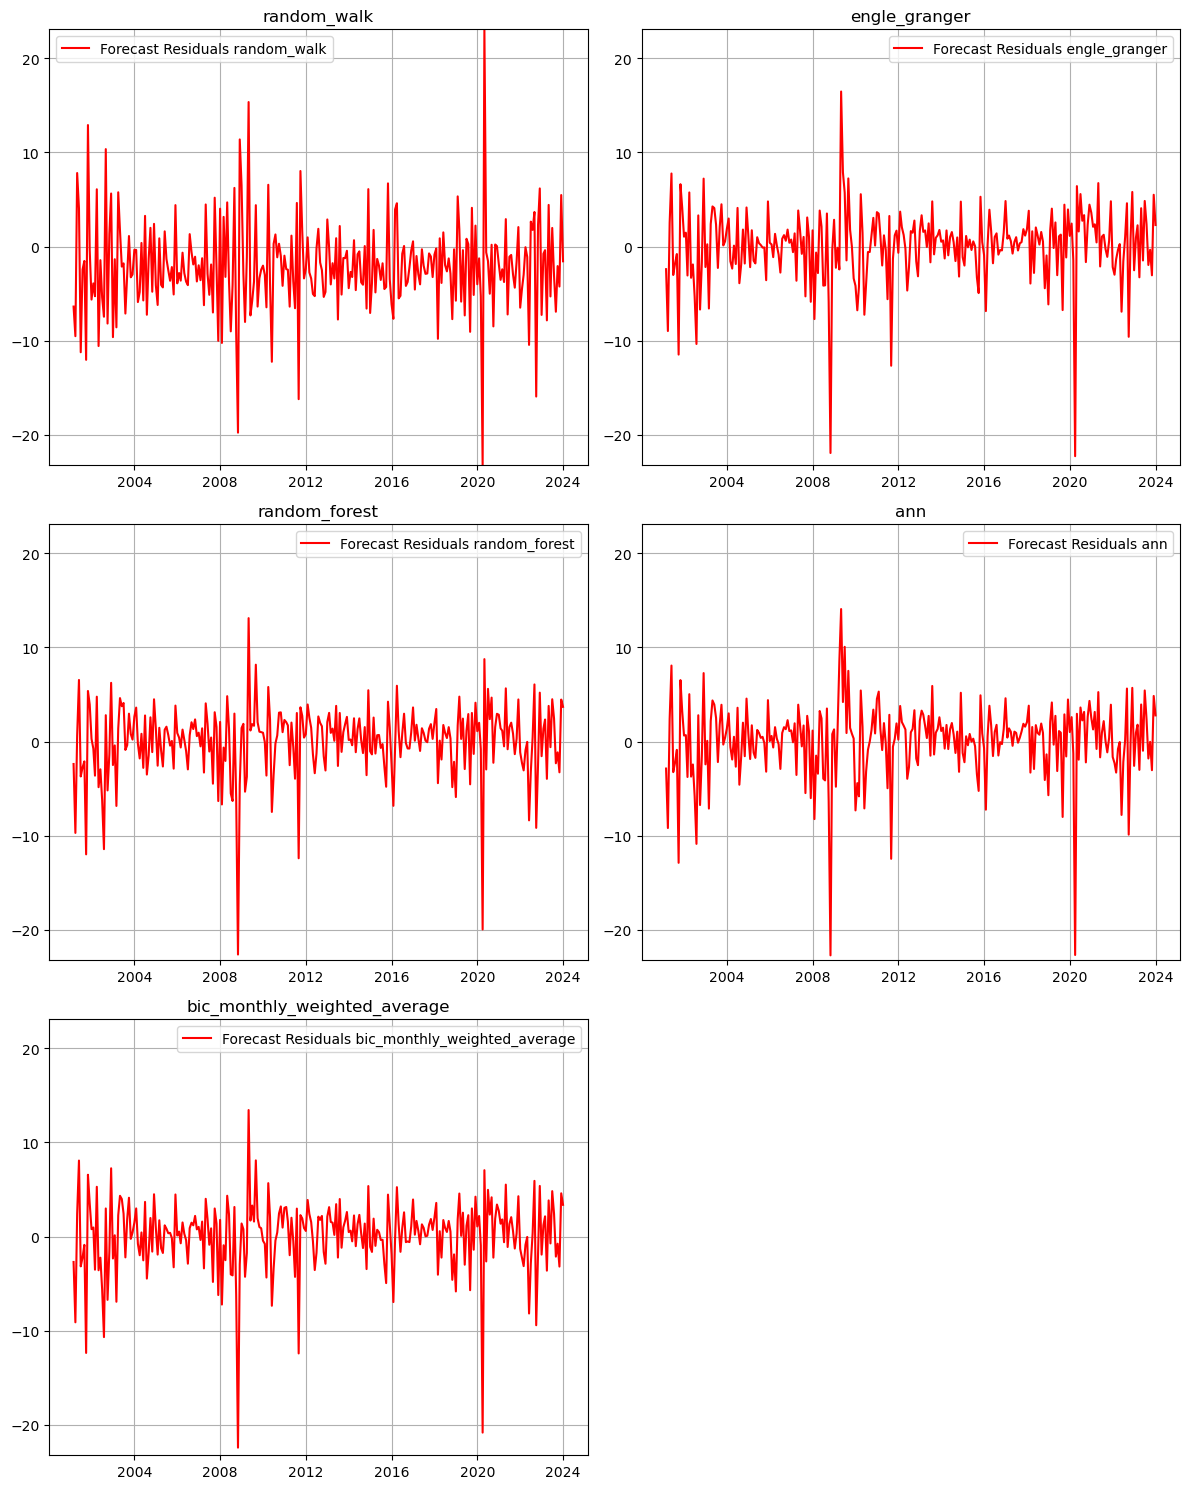

In [49]:
# Supponiamo che all_models_forecast_over_time_df sia già definito
observed_returns = all_models_forecast_over_time_df["observed_sp500_returns"]

# Troviamo i limiti minimi e massimi per i forecast residuals
y_min = min(data["forecast_residuals"].min() for data in models_dict.values())
y_max = max(data["forecast_residuals"].max() for data in models_dict.values())

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):

    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot dei forecast residuals
    ax.plot(data["forecast_residuals"], label=f"Forecast Residuals {model_name}", color='red')

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)

# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


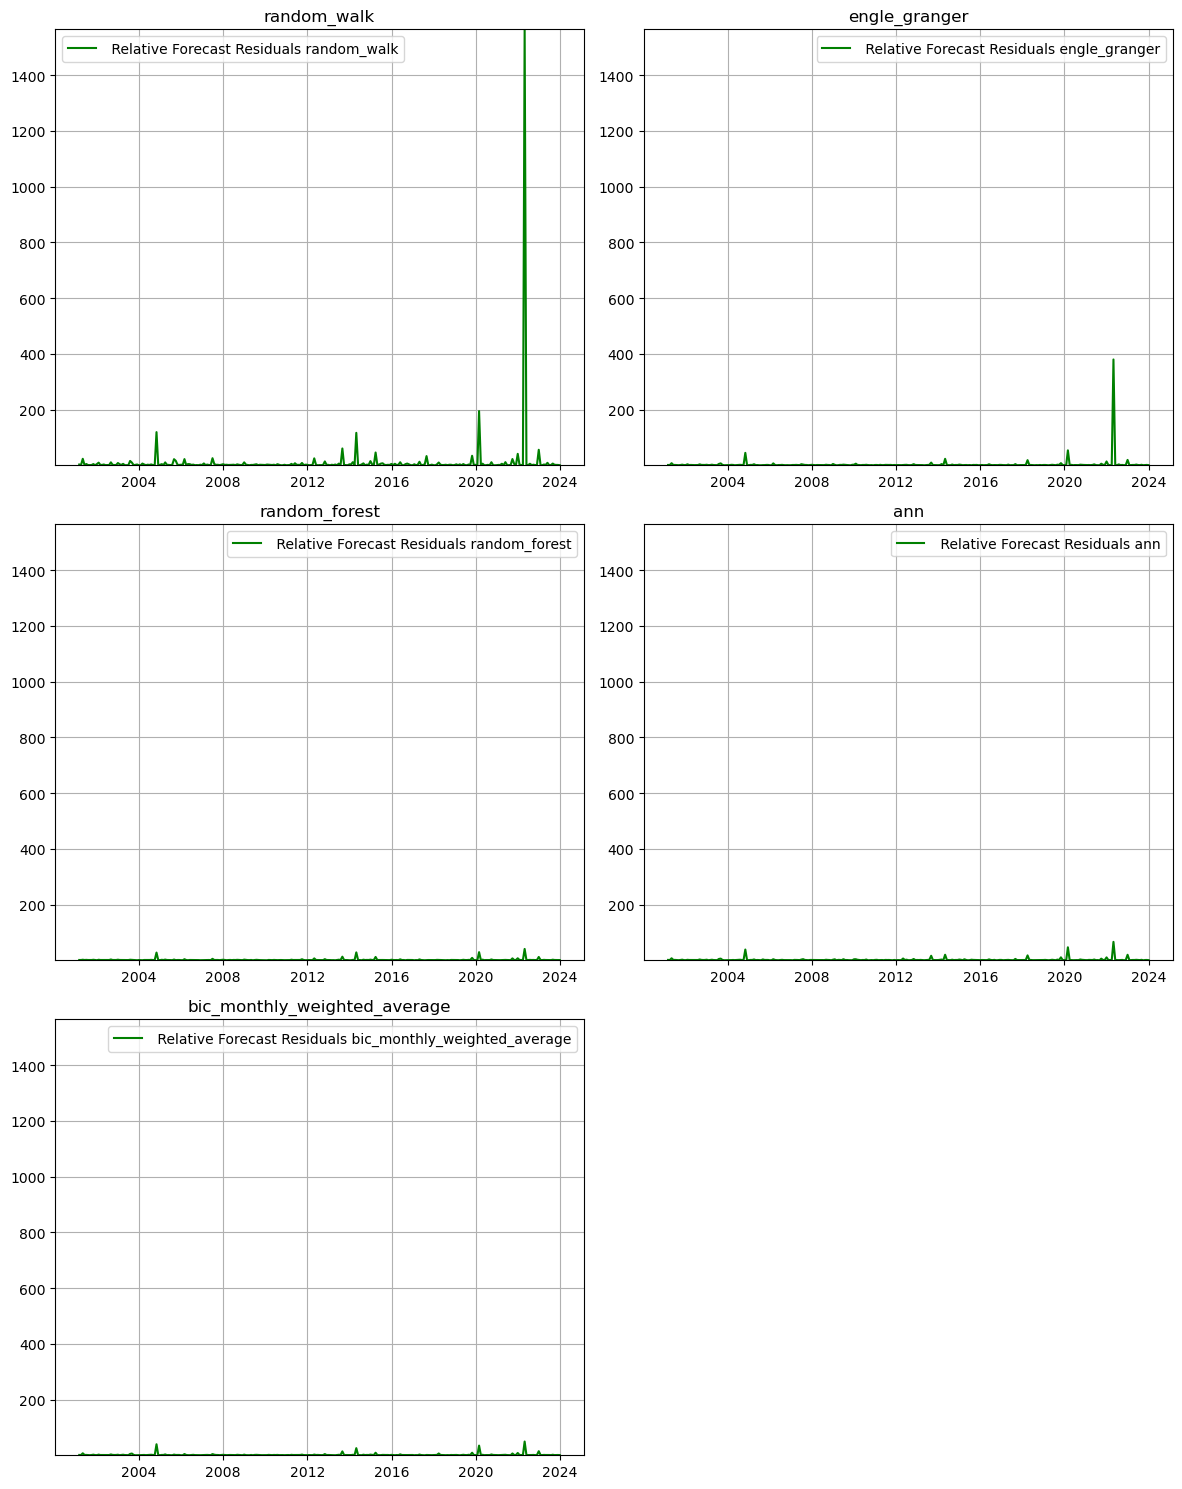

In [50]:
# Supponiamo che all_models_forecast_over_time_df sia già definito
observed_returns = all_models_forecast_over_time_df["observed_sp500_returns"]

# Troviamo i limiti minimi e massimi per i forecast residuals
y_min = min(data["relative_forecast_residuals"].min() for data in models_dict.values())
y_max = max(data["relative_forecast_residuals"].max() for data in models_dict.values())

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

relative_forecast_residuals_df = pd.DataFrame()

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):

    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot dei forecast residuals
    ax.plot(data["relative_forecast_residuals"], label=f" Relative Forecast Residuals {model_name}", color='g')

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)
    
    relative_forecast_residuals_df[model_name] = data["relative_forecast_residuals"]


# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


In [51]:
relative_forecast_residuals_df.head()

random_walk  engle_granger  random_forest       ann  \
2001-02-28     2.814383       1.059006       1.050839  1.264707   
2001-03-31     0.987808       0.930935       1.006872  0.953012   
2001-04-30    23.276508       7.503820       1.921100  7.164668   
2001-05-31     0.620693       1.186167       1.000252  1.233959   
2001-06-30     4.446422       1.194167       1.465850  1.283774   

            bic_monthly_weighted_average  
2001-02-28                      1.190364  
2001-03-31                      0.945024  
2001-04-30                      7.164668  
2001-05-31                      1.233959  
2001-06-30                      1.251175

In [52]:
relative_forecast_residuals_df.to_csv("relative_forecast_residuals_df.csv", index=False)


In [53]:
relative_forecast_residuals_random_walk = (models_dict["random_walk"]["relative_forecast_residuals"])
print(relative_forecast_residuals_random_walk.idxmax(),relative_forecast_residuals_random_walk.max())

2022-04-30 00:00:00 1564.461009193734


In [54]:
relative_forecast_residuals_engle_granger = (models_dict["engle_granger"]["relative_forecast_residuals"])
print(relative_forecast_residuals_engle_granger.idxmax(),relative_forecast_residuals_engle_granger.max())

2022-04-30 00:00:00 379.72255726760494


In [55]:
relative_forecast_residuals_random_forest = (models_dict["random_forest"]["relative_forecast_residuals"])
print(relative_forecast_residuals_random_forest.idxmax(),relative_forecast_residuals_random_forest.max())

2022-04-30 00:00:00 40.64393329082472


In [56]:
relative_forecast_residuals_ann = (models_dict["ann"]["relative_forecast_residuals"])
print(relative_forecast_residuals_ann.idxmax(),relative_forecast_residuals_ann.max())

2022-04-30 00:00:00 66.09577881278726


In [57]:
relative_forecast_residuals_bic_monthly_weighted_average = (models_dict["bic_monthly_weighted_average"]["relative_forecast_residuals"])
print(relative_forecast_residuals_bic_monthly_weighted_average.idxmax(),relative_forecast_residuals_bic_monthly_weighted_average.max())

2022-04-30 00:00:00 49.34800602369727


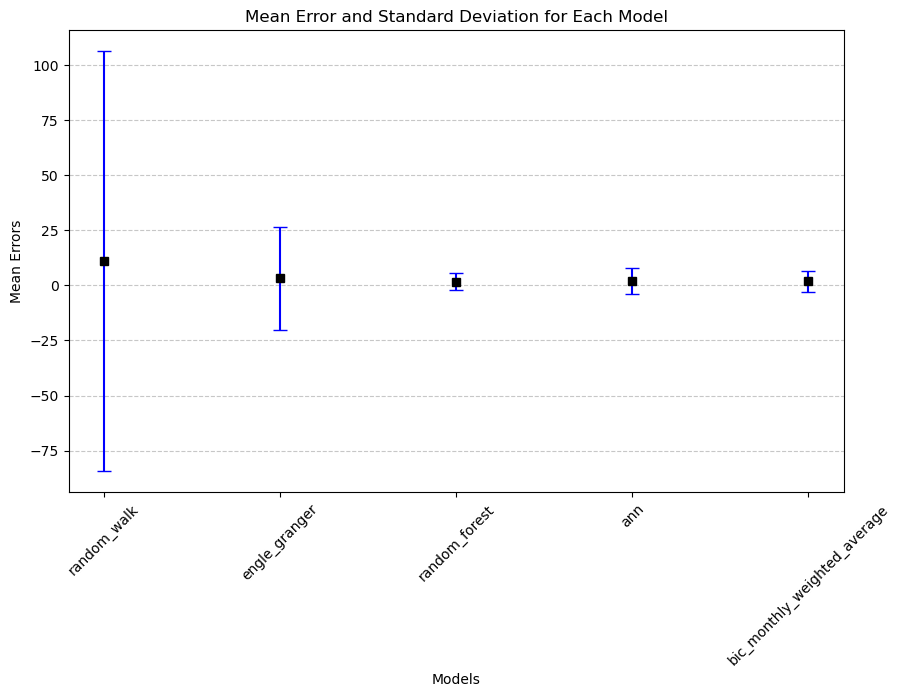

In [58]:
# Standard deviation of relative forecast residuals
results = {}

# Ciclo sui modelli
for model_name, model_data in models_dict.items():
    mean_residuals = np.mean(model_data["relative_forecast_residuals"])
    std_residuals = np.std(model_data["relative_forecast_residuals"])
    results[model_name] = (mean_residuals, std_residuals)

# Estrarre i nomi dei modelli e i valori calcolati
models = list(results.keys())
means = [results[m][0] for m in models]
std_devs = [results[m][1] for m in models]

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.errorbar(models, means, yerr=std_devs, fmt='s', capsize=5, color='black', ecolor='blue')

# Aggiungere etichette e titolo
plt.xlabel("Models")
plt.ylabel("Mean Errors")
plt.title("Mean Error and Standard Deviation for Each Model")
plt.xticks(rotation=45)  # Ruota le etichette per migliore leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.show()


# Array definition

In [59]:
'''
# Arrays Definition
y_true_array = np.array(y_true_list)
forecast_random_walk_array = np.array(forecast_random_walk_list)
forecast_engle_granger_array = np.array(forecast_engle_granger_list)
forecast_rf_array = np.array(forecast_rf_list)
forecast_svr_array = np.array(forecast_svr_list)
forecast_ann_array = np.array(forecast_ann_list)
forecast_ensemble_learning_simple_mean_array = np.array(forecast_ensemble_learning_simple_mean_list)
forecast_ensemble_learning_weighted_r2_array = np.array(forecast_ensemble_learning_weighted_r2_list)
forecast_ensemble_learning_weighted_rmse_array = np.array(forecast_ensemble_learning_weighted_rmse_list)
forecast_ensemble_learning_weighted_test_rmse_array = np.array(forecast_ensemble_learning_weighted_test_rmse_list)

#  Arrays Definition Gianfreda Scandolo
forecast_bic_monthly_best_array = np.array(forecast_bic_monthly_best_list)
forecast_aic_monthly_best_array = np.array(forecast_aic_monthly_best_list)
forecast_bic_monthly_weighted_average_array = np.array(forecast_bic_monthly_weighted_average_list)
forecast_aic_monthly_weighted_average_array = np.array(forecast_aic_monthly_weighted_average_list)
'''

'\n# Arrays Definition\ny_true_array = np.array(y_true_list)\nforecast_random_walk_array = np.array(forecast_random_walk_list)\nforecast_engle_granger_array = np.array(forecast_engle_granger_list)\nforecast_rf_array = np.array(forecast_rf_list)\nforecast_svr_array = np.array(forecast_svr_list)\nforecast_ann_array = np.array(forecast_ann_list)\nforecast_ensemble_learning_simple_mean_array = np.array(forecast_ensemble_learning_simple_mean_list)\nforecast_ensemble_learning_weighted_r2_array = np.array(forecast_ensemble_learning_weighted_r2_list)\nforecast_ensemble_learning_weighted_rmse_array = np.array(forecast_ensemble_learning_weighted_rmse_list)\nforecast_ensemble_learning_weighted_test_rmse_array = np.array(forecast_ensemble_learning_weighted_test_rmse_list)\n\n#  Arrays Definition Gianfreda Scandolo\nforecast_bic_monthly_best_array = np.array(forecast_bic_monthly_best_list)\nforecast_aic_monthly_best_array = np.array(forecast_aic_monthly_best_list)\nforecast_bic_monthly_weighted_ave

#  Test RMSE for all models

In [60]:
rmse_dict = {}

# Identifica le colonne che contengono i forecast (escludendo intervalli di confidenza)
forecast_columns = [col for col in all_models_forecast_over_time_df.columns if col.startswith("forecast_")]

observed_sp500_returns = all_models_forecast_over_time_df["observed_sp500_returns"]

# Calcola l'RMSE per ogni modello
for col in forecast_columns:
    y_pred = all_models_forecast_over_time_df[col]  # Valori previsti
    rmse = np.sqrt(np.mean((observed_sp500_returns - y_pred) ** 2))  # RMSE formula
    rmse_dict[col] = rmse  # Salva nel dizionario

rmse_dict

{'forecast_randomwalk': 5.389585054687646,
 'forecast_engle_granger': 3.9252933713573426,
 'forecast_rf': 3.8290239376363924,
 'forecast_svr': 3.981016966626558,
 'forecast_ann': 4.003450356329726,
 'forecast_ensemble_learning_simple_mean': 3.833106146358281,
 'forecast_ensemble_learning_weighted_r2': 3.852272814590079,
 'forecast_ensemble_learning_weighted_rmse': 3.832362260113213,
 'forecast_ensemble_learning_weighted_test_rmse': 3.828993787667512,
 'forecast_bic_monthly_best': 3.8436865114695675,
 'forecast_aic_monthly_best': 3.8436865114695675,
 'forecast_bic_monthly_weighted_average': 3.8131421043977287,
 'forecast_aic_monthly_weighted_average': 3.809555176512695,
 'forecast_bic_monthly_weighted_average_converted': 2267.148670776719}

## Metrics Table

In [61]:
# Creazione del DataFrame
rmse_df = pd.DataFrame(list(rmse_dict.items()), columns=["Model", "RMSE"] )
# Imposta la colonna "Model" come indice
rmse_df.set_index("Model", inplace=True)
print(tabulate(rmse_df, headers="keys", tablefmt="plain", stralign="left"))

Model                                                  RMSE
forecast_randomwalk                                 5.38959
forecast_engle_granger                              3.92529
forecast_rf                                         3.82902
forecast_svr                                        3.98102
forecast_ann                                        4.00345
forecast_ensemble_learning_simple_mean              3.83311
forecast_ensemble_learning_weighted_r2              3.85227
forecast_ensemble_learning_weighted_rmse            3.83236
forecast_ensemble_learning_weighted_test_rmse       3.82899
forecast_bic_monthly_best                           3.84369
forecast_aic_monthly_best                           3.84369
forecast_bic_monthly_weighted_average               3.81314
forecast_aic_monthly_weighted_average               3.80956
forecast_bic_monthly_weighted_average_converted  2267.15


# T-test

In [62]:
# Supponiamo che questi siano i tuoi errori calcolati (sostituiscili con i tuoi dati reali)
errors_dict = {
    "random_walk": models_dict["random_walk"]["forecast_residuals"],
    "engle_granger": models_dict["engle_granger"]["forecast_residuals"],
    "Random_forest": models_dict["random_forest"]["forecast_residuals"],
    #"svr": models_dict["svr"]["forecast_residuals"],
    "ann": models_dict["ann"]["forecast_residuals"],
    "bic_monthly_weighted_average": models_dict["bic_monthly_weighted_average"]["forecast_residuals"],
    }


# Generiamo tutte le coppie possibili di modelli
model_pairs = list(itertools.combinations(errors_dict.keys(), 2))

# Eseguiamo il test t per ogni coppia
t_test_results = []
for model1, model2 in model_pairs:
    t_stat, p_value = ttest_rel(errors_dict[model1], errors_dict[model2])
    t_test_results.append((model1, model2, t_stat, p_value))



In [63]:
# Creiamo una matrice quadrata inizializzata con NaN
p_value_matrix_forecast_residuals = pd.DataFrame(np.nan, index = errors_dict.keys(), columns = errors_dict.keys())

# Inseriamo i p-value nei punti corretti della matrice (simmetrica)
for model1, model2, t_stat, p_value in t_test_results:
    p_value_matrix_forecast_residuals.loc[model1, model2] = round(p_value, 4)
    p_value_matrix_forecast_residuals.loc[model2, model1] = round(p_value, 4)  # Simmetria

p_value_matrix_forecast_residuals


random_walk  engle_granger  Random_forest  \
random_walk                           NaN         0.0000         0.0000   
engle_granger                         0.0            NaN         0.8034   
Random_forest                         0.0         0.8034            NaN   
ann                                   0.0         0.6721         0.6269   
bic_monthly_weighted_average          0.0         0.6291         0.1481   

                                 ann  bic_monthly_weighted_average  
random_walk                   0.0000                        0.0000  
engle_granger                 0.6721                        0.6291  
Random_forest                 0.6269                        0.1481  
ann                              NaN                        0.9736  
bic_monthly_weighted_average  0.9736                           NaN

In [64]:
# Errori relativi

relative_errors_dict = {
    "random_walk": models_dict["random_walk"]["relative_forecast_residuals"],
    "engle_granger": models_dict["engle_granger"]["relative_forecast_residuals"],
    "Random_forest": models_dict["random_forest"]["relative_forecast_residuals"],
    #"svr": models_dict["svr"]["relative_forecast_residuals"],
    "ann": models_dict["ann"]["relative_forecast_residuals"],
    "bic_monthly_weighted_average": models_dict["bic_monthly_weighted_average"]["relative_forecast_residuals"],
    }


# Generiamo tutte le coppie possibili di modelli
model_pairs = list(itertools.combinations(relative_errors_dict.keys(), 2))

# Eseguiamo il test t per ogni coppia
t_test_results_relative_residuals = []
for model1, model2 in model_pairs:
    t_stat, p_value = ttest_rel(relative_errors_dict[model1], relative_errors_dict[model2])
    t_test_results_relative_residuals.append((model1, model2, t_stat, p_value))



In [65]:
# Creiamo una matrice quadrata inizializzata con NaN
p_value_matrix_forecast_relative_residuals = pd.DataFrame(np.nan, index = relative_errors_dict.keys(), columns = relative_errors_dict.keys())

# Inseriamo i p-value nei punti corretti della matrice (simmetrica)
for model1, model2, t_stat, p_value in t_test_results_relative_residuals:
    p_value_matrix_forecast_relative_residuals.loc[model1, model2] = round(p_value, 4)
    p_value_matrix_forecast_relative_residuals.loc[model2, model1] = round(p_value, 4)  # Simmetria

p_value_matrix_forecast_relative_residuals


random_walk  engle_granger  Random_forest  \
random_walk                           NaN         0.0758         0.0978   
engle_granger                      0.0758            NaN         0.2238   
Random_forest                      0.0978         0.2238            NaN   
ann                                0.1045         0.3066         0.0241   
bic_monthly_weighted_average       0.1008         0.2556         0.0534   

                                 ann  bic_monthly_weighted_average  
random_walk                   0.1045                        0.1008  
engle_granger                 0.3066                        0.2556  
Random_forest                 0.0241                        0.0534  
ann                              NaN                        0.0405  
bic_monthly_weighted_average  0.0405                           NaN

## Weights Table

In [66]:
'''
# Creation of the statistics dictionary for BIC weights
stat_dict_bic = {
    'Engle Granger BIC': {
        'Mean': np.mean(weight_bic_engle_granger_list),
        'Std Dev': np.std(weight_bic_engle_granger_list),
        'Min': np.min(weight_bic_engle_granger_list),
        'Max': np.max(weight_bic_engle_granger_list),
    },
    'Random Forest BIC': {
        'Mean': np.mean(weight_bic_rf_list),
        'Std Dev': np.std(weight_bic_rf_list),
        'Min': np.min(weight_bic_rf_list),
        'Max': np.max(weight_bic_rf_list),
    },
    'SVR BIC': {
        'Mean': np.mean(weight_bic_svr_list),
        'Std Dev': np.std(weight_bic_svr_list),
        'Min': np.min(weight_bic_svr_list),
        'Max': np.max(weight_bic_svr_list),
    },
    'ANN BIC': {
        'Mean': np.mean(weight_bic_ann_list),
        'Std Dev': np.std(weight_bic_ann_list),
        'Min': np.min(weight_bic_ann_list),
        'Max': np.max(weight_bic_ann_list),
    }
}

# Creation of the statistics dictionary for AIC weights
stat_dict_aic = {
    'Engle Granger AIC': {
        'Mean': np.mean(weight_aic_engle_granger_list),
        'Std Dev': np.std(weight_aic_engle_granger_list),
        'Min': np.min(weight_aic_engle_granger_list),
        'Max': np.max(weight_aic_engle_granger_list),
    },
    'Random Forest AIC': {
        'Mean': np.mean(weight_aic_rf_list),
        'Std Dev': np.std(weight_aic_rf_list),
        'Min': np.min(weight_aic_rf_list),
        'Max': np.max(weight_aic_rf_list),
    },
    'SVR AIC': {
        'Mean': np.mean(weight_aic_svr_list),
        'Std Dev': np.std(weight_aic_svr_list),
        'Min': np.min(weight_aic_svr_list),
        'Max': np.max(weight_aic_svr_list),
    },
    'ANN AIC': {
        'Mean': np.mean(weight_aic_ann_list),
        'Std Dev': np.std(weight_aic_ann_list),
        'Min': np.min(weight_aic_ann_list),
        'Max': np.max(weight_aic_ann_list),
    }
}

# Creation of DataFrames from the statistics dictionaries
stat_df_bic = pd.DataFrame(stat_dict_bic).T  # Transpose to have models as rows and statistics as columns
stat_df_aic = pd.DataFrame(stat_dict_aic).T
stat_df = pd.concat([stat_df_bic, stat_df_aic], axis=0)
print(stat_df)
'''

"\n# Creation of the statistics dictionary for BIC weights\nstat_dict_bic = {\n    'Engle Granger BIC': {\n        'Mean': np.mean(weight_bic_engle_granger_list),\n        'Std Dev': np.std(weight_bic_engle_granger_list),\n        'Min': np.min(weight_bic_engle_granger_list),\n        'Max': np.max(weight_bic_engle_granger_list),\n    },\n    'Random Forest BIC': {\n        'Mean': np.mean(weight_bic_rf_list),\n        'Std Dev': np.std(weight_bic_rf_list),\n        'Min': np.min(weight_bic_rf_list),\n        'Max': np.max(weight_bic_rf_list),\n    },\n    'SVR BIC': {\n        'Mean': np.mean(weight_bic_svr_list),\n        'Std Dev': np.std(weight_bic_svr_list),\n        'Min': np.min(weight_bic_svr_list),\n        'Max': np.max(weight_bic_svr_list),\n    },\n    'ANN BIC': {\n        'Mean': np.mean(weight_bic_ann_list),\n        'Std Dev': np.std(weight_bic_ann_list),\n        'Min': np.min(weight_bic_ann_list),\n        'Max': np.max(weight_bic_ann_list),\n    }\n}\n\n# Creation of

# Weights plots

In [67]:
models_weights_over_time_df.head()

random_forest  engle_granger       ann  return_sp_500
2001-02-28            NaN       0.415424  0.734021      -2.262550
2001-03-31            NaN       0.416067  0.733821      -9.631777
2001-04-30            NaN            NaN  0.990366       0.335903
2001-05-31            NaN            NaN  0.989375       6.548935
2001-06-30            NaN       0.415184  0.726047      -2.523768

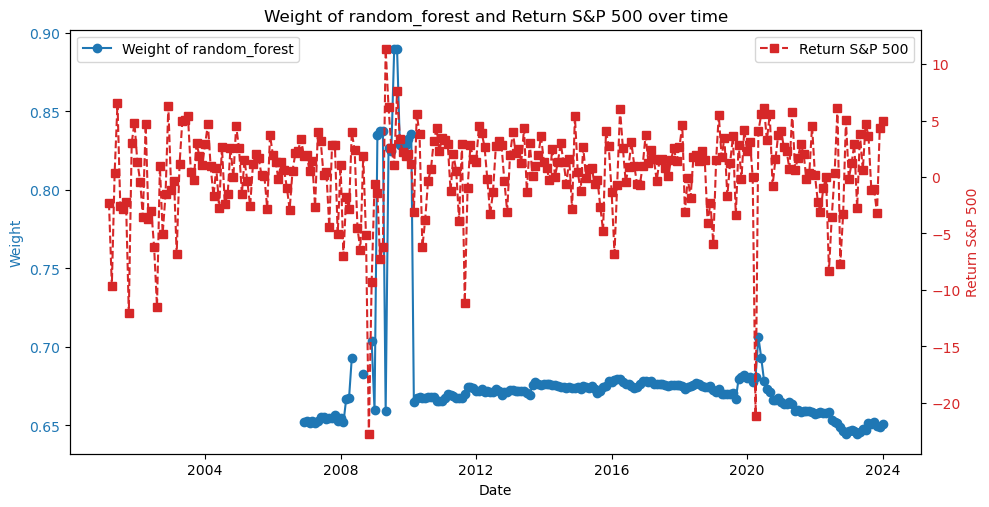

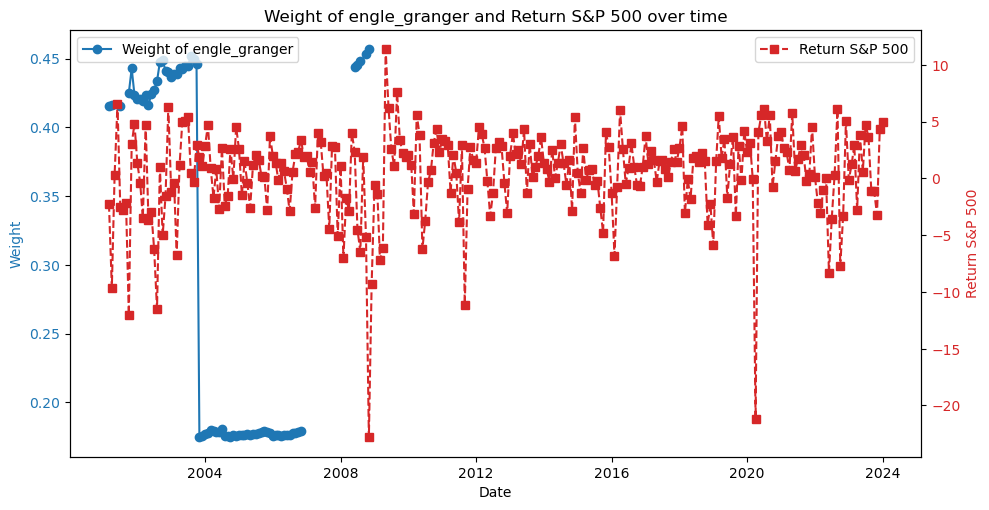

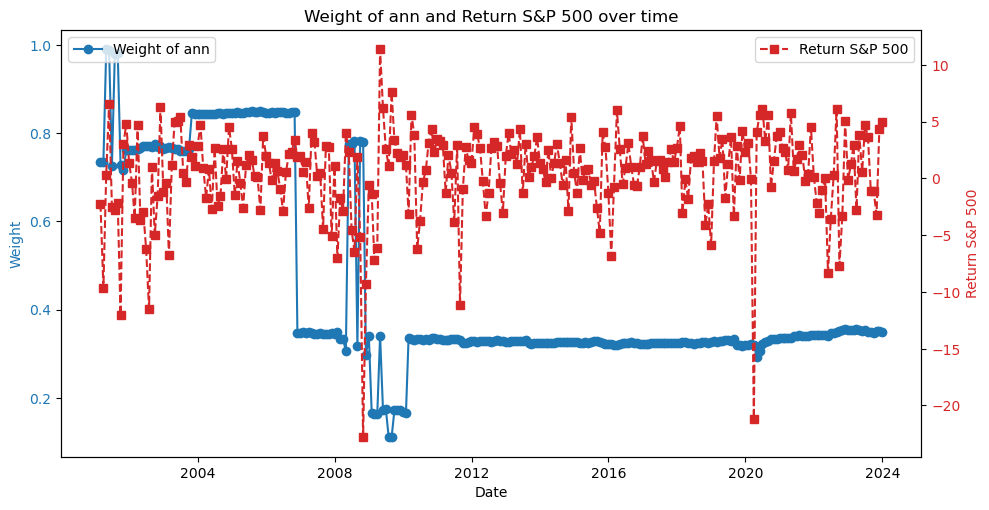

In [68]:
# Creiamo i grafici
for model_name in models_weights_over_time_df.columns[:-1]:  # Escludiamo la colonna 'return_sp_500'
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weight', color='tab:blue')
    ax1.plot(models_weights_over_time_df.index, models_weights_over_time_df[model_name], marker='o', linestyle='-', color='tab:blue', label=f'Weight of {model_name}')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Return S&P 500', color='tab:red')
    ax2.plot(models_weights_over_time_df.index, models_weights_over_time_df['return_sp_500'], marker='s', linestyle='dashed', color='tab:red', label='Return S&P 500')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    plt.title(f'Weight of {model_name} and Return S&P 500 over time')
    plt.savefig(f'plots/Weight_of_{model_name}_and_Return_S&P_500_over_time.svg', format='svg')

    plt.show()

# Hit Ratio

In [69]:
# Hit Ratio
all_models_forecast_over_time_df.head()
def binarize_returns(returns):
    
    binarized_returns_list = []
    
    for value in returns:
        
        if value >= 0:
            
            value = 1
            
        else:
            
            value = 0
            
        binarized_returns_list.append(value)
        
    returns = pd.Series(binarized_returns_list, index=returns.index)
    
    return returns 

In [70]:
# Binarized Dataframe creation
for colonna in all_models_forecast_over_time_df.columns:
    
    if colonna == "observed_sp500_returns":
        binarized_observed_sp500_returns = binarize_returns(all_models_forecast_over_time_df[colonna])
        df_binarized = pd.DataFrame(index=all_models_forecast_over_time_df.index)
        df_binarized[colonna] = binarized_observed_sp500_returns
    
    elif colonna.startswith("forecast_"):
        binarized_forecast = binarize_returns(all_models_forecast_over_time_df[colonna])
        df_binarized[colonna] = binarized_forecast
  
df_binarized.head(10)  
    
hit_ratio_df = pd.DataFrame(columns = ["hit_ratio_percent"] , index = df_binarized.columns[1:])


    
df_binarized.head()

observed_sp500_returns  forecast_randomwalk  \
2001-02-28                       0                    1   
2001-03-31                       0                    0   
2001-04-30                       1                    0   
2001-05-31                       1                    1   
2001-06-30                       0                    1   

            forecast_engle_granger  forecast_rf  forecast_svr  forecast_ann  \
2001-02-28                       1            1             1             1   
2001-03-31                       0            1             1             0   
2001-04-30                       0            0             0             0   
2001-05-31                       0            0             1             0   
2001-06-30                       1            1             1             1   

            forecast_ensemble_learning_simple_mean  \
2001-02-28                                       1   
2001-03-31                                       0   
2001-04-30                                       0   
2001-05-31                                       0   
2001-06-30                                       1   

            forecast_ensemble_learning_weighted_r2  \
2001-02-28                                       1   
2001-03-31                                       0   
2001-04-30                                       0   
2001-05-31                                       0   
2001-06-30                                       1   

            forecast_ensemble_learning_weighted_rmse  \
2001-02-28                                         1   
2001-03-31                                         0   
2001-04-30                                         0   
2001-05-31                                         0   
2001-06-30                                         1   

            forecast_ensemble_learning_weighted_test_rmse  \
2001-02-28                                              1   
2001-03-31                                              0   
2001-04-30                                              0   
2001-05-31                                              0   
2001-06-30                                              1   

            forecast_bic_monthly_best  forecast_aic_monthly_best  \
2001-02-28                          1                          1   
2001-03-31                          0                          0   
2001-04-30                          0                          0   
2001-05-31                          0                          0   
2001-06-30                          1                          1   

            forecast_bic_monthly_weighted_average  \
2001-02-28                                      1   
2001-03-31                                      0   
2001-04-30                                      0   
2001-05-31                                      0   
2001-06-30                                      1   

            forecast_aic_monthly_weighted_average  \
2001-02-28                                      1   
2001-03-31                                      0   
2001-04-30                                      0   
2001-05-31                                      0   
2001-06-30                                      1   

            forecast_bic_monthly_weighted_average_converted  
2001-02-28                                                1  
2001-03-31                                                1  
2001-04-30                                                1  
2001-05-31                                                1  
2001-06-30                                                1

In [71]:
for column in df_binarized.columns:
    
    if column == "observed_sp500_returns":
        continue
    
    comparison = df_binarized[column] == df_binarized["observed_sp500_returns"]
    num_hit_ratio = 0
    
    for value in comparison:
        if value == True:
            num_hit_ratio += 1
            
    hit_ratio = num_hit_ratio / len(comparison) * 100
    hit_ratio_df.loc[column] = hit_ratio

In [72]:
hit_ratio_df

hit_ratio_percent
forecast_randomwalk                                          64.0
forecast_engle_granger                                  61.818182
forecast_rf                                             62.909091
forecast_svr                                            62.909091
forecast_ann                                            60.727273
forecast_ensemble_learning_simple_mean                  62.545455
forecast_ensemble_learning_weighted_r2                  62.181818
forecast_ensemble_learning_weighted_rmse                62.181818
forecast_ensemble_learning_weighted_test_rmse           62.181818
forecast_bic_monthly_best                               62.909091
forecast_aic_monthly_best                               62.909091
forecast_bic_monthly_weighted_average                   62.181818
forecast_aic_monthly_weighted_average                   62.181818
forecast_bic_monthly_weighted_average_converted         63.636364

#  Forecast plot for each model

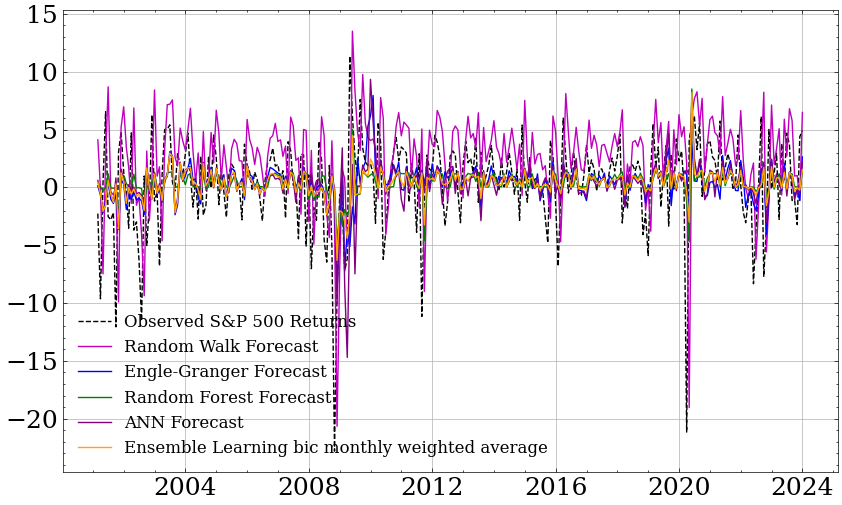

In [73]:
with plt.style.context('science'):
    plt.rcParams['text.usetex'] = False  # Disable LaTeX rendering

    plt.figure(figsize=(10, 6))
    plt.plot(all_models_forecast_over_time_df.index, all_models_forecast_over_time_df["observed_sp500_returns"], label="Observed S&P 500 Returns", color="black", linestyle="--")
    plt.plot(all_models_forecast_over_time_df.index, all_models_forecast_over_time_df["forecast_randomwalk"], label="Random Walk Forecast", color="m")
    plt.plot(all_models_forecast_over_time_df.index, all_models_forecast_over_time_df["forecast_engle_granger"], label="Engle-Granger Forecast", color="b")
    plt.plot(all_models_forecast_over_time_df.index, all_models_forecast_over_time_df["forecast_rf"], label="Random Forest Forecast", color="g")
    #plt.plot(all_models_forecast_over_time_df.index, all_models_forecast_over_time_df["forecast_svr"], label="SVR Forecast", color="r")
    plt.plot(all_models_forecast_over_time_df.index, all_models_forecast_over_time_df["forecast_ann"], label="ANN Forecast", color="purple")
    plt.plot(all_models_forecast_over_time_df.index, all_models_forecast_over_time_df["forecast_bic_monthly_weighted_average"], label="Ensemble Learning bic monthly weighted average", color="orange")

    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=12, loc='lower left')

    plt.savefig('plots/all_the relevant_forecasts.svg', format='svg')

    plt.show()

In [74]:
len_forecast_columns = len(forecast_columns)
len_forecast_columns

14

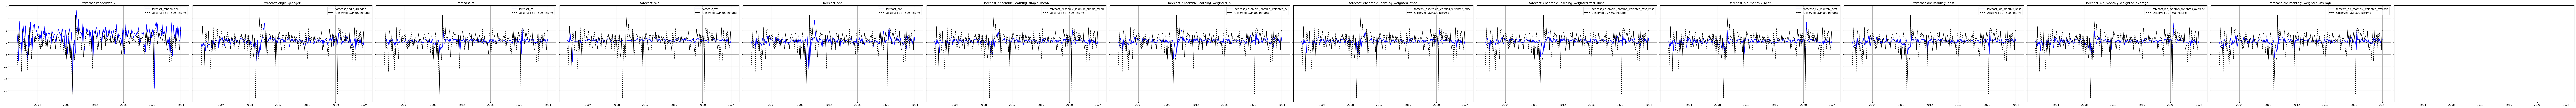

In [75]:

# Prendere l'indice come asse x (date)
x = all_models_forecast_over_time_df.index
num_cols = len(forecast_columns)

# Creare una figura con sottografi affiancati
fig, axes = plt.subplots(1, num_cols, figsize=(10*num_cols, 6), sharex=True, sharey=True)

# Se c'è un solo grafico, assicuriamoci che 'axes' sia una lista
if num_cols == 1:
    axes = [axes]

# Creare i singoli grafici
for i, col in enumerate(forecast_columns[:-1]):
    axes[i].plot(x, all_models_forecast_over_time_df[col], label=col, color="b")
    axes[i].plot(x, all_models_forecast_over_time_df["observed_sp500_returns"], label="Observed S&P 500 Returns", color="black", linestyle="--")
    axes[i].set_title(col)
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()  # Migliora la disposizione dei grafici
plt.show()


## Random walk forecast plot

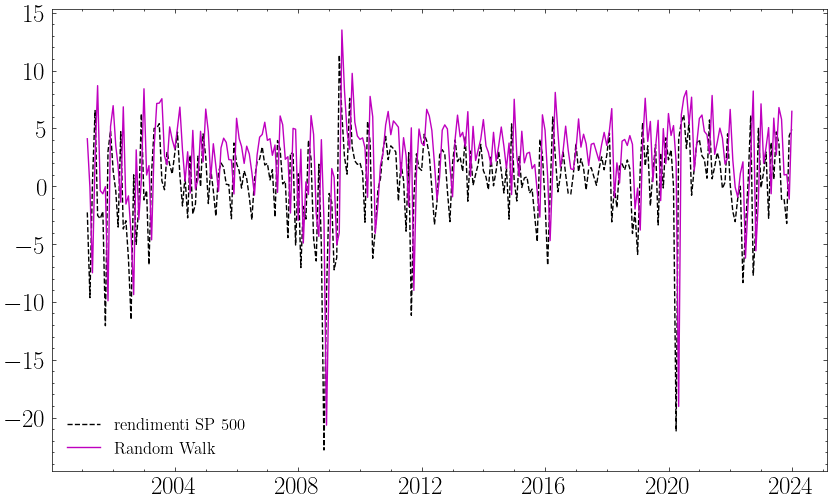

In [76]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast
    plt.plot(date_list, forecast_random_walk_list, label='Random Walk', color='m',)

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')

    plt.savefig('plots/forecast_random_walk.svg', format='svg')

    plt.show()


## Engle-Granger forecast plot

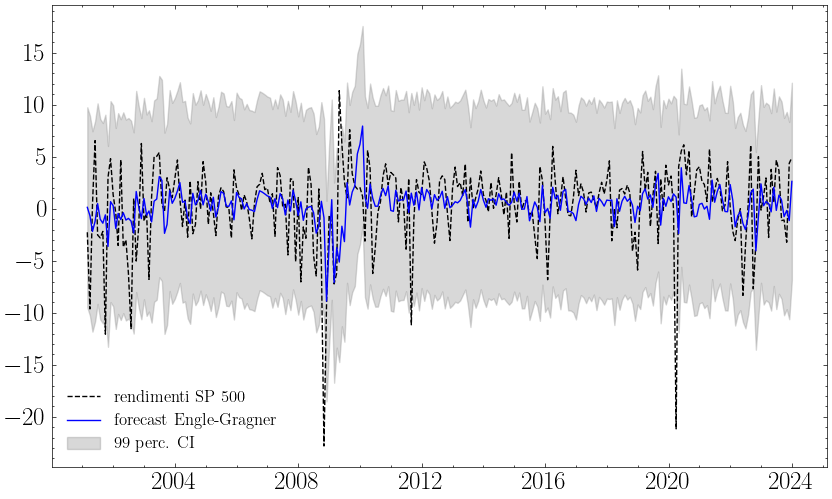

In [77]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_engle_granger_list, label='forecast Engle-Gragner', color='blue')
    plt.fill_between(date_list, lower_bound_engle_granger_list, upper_bound_engle_granger_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')

    plt.savefig('plots/forecast_Engle-Gragner_CI.svg', format='svg')

    plt.show()

## Forecast Random Forest plot

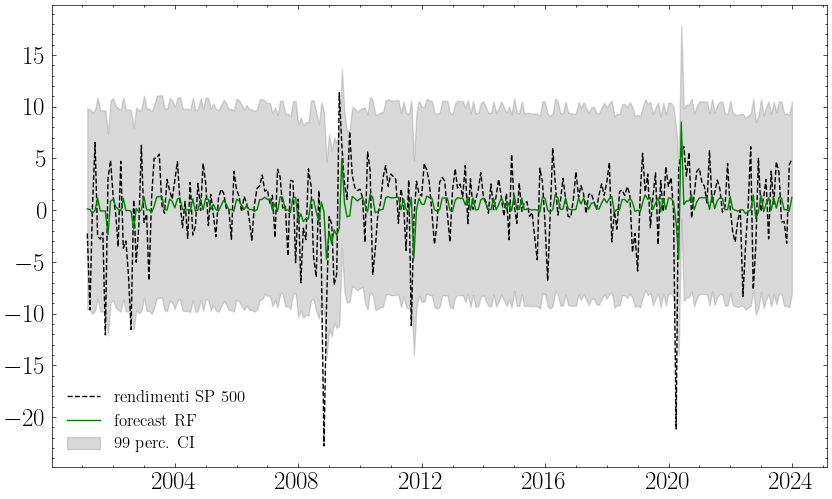

In [78]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_rf_list, label='forecast RF', color='green')
    plt.fill_between(date_list, lower_bound_rf_list, upper_bound_rf_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')

    plt.savefig('plots/forecast_random_forest_CI.svg', format='svg')

    plt.show()

## Forecast SVR plot

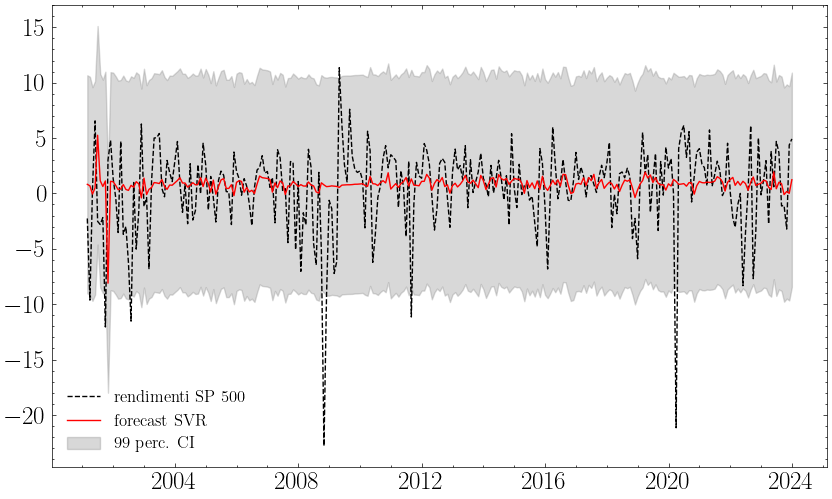

In [79]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_svr_list, label='forecast SVR', color='red')
    plt.fill_between(date_list, lower_bound_svr_list, upper_bound_svr_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_svr_CI.svg', format='svg')

    plt.show()

## Forecast SVR  converted plot

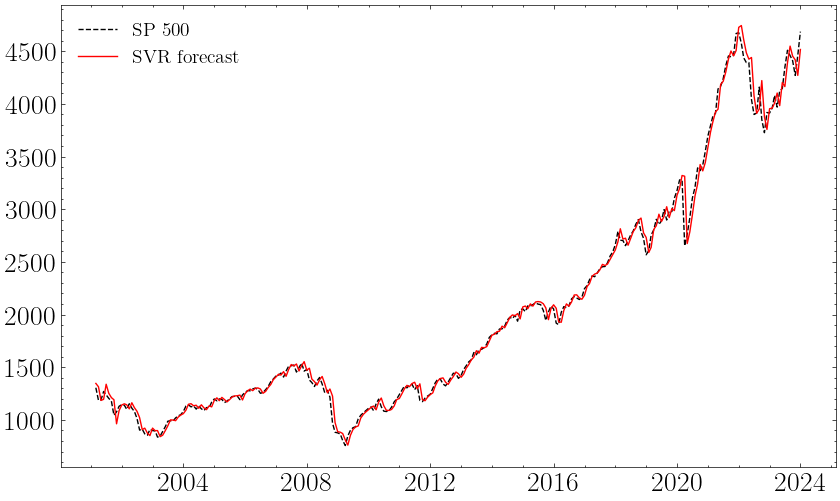

In [80]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, sp_500_true_list, label='SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_svr_converted_list, label='SVR forecast', color='red')
    #plt.fill_between(date_list,lower_bound_bic_weighted_average_converted_list , upper_bound_bic_weighted_average_converted_list, color='gray', alpha=0.4, label='99 perc. CI')

        
    plt.xticks(fontsize=20)  
    plt.yticks(fontsize=20)
    plt.grid(False)
    plt.legend(fontsize=14, loc='upper left')
    plt.savefig('plots/forecast_svr_converted.svg', format='svg')

    plt.show()

## Forecast ANN plot

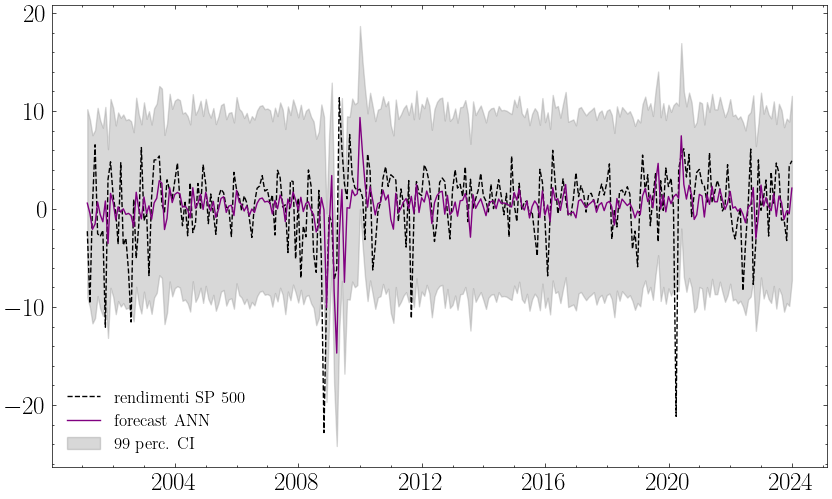

In [81]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_ann_list, label='forecast ANN', color='purple')
    plt.fill_between(date_list, lower_bound_ann_list, upper_bound_ann_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_ann_CI.svg', format='svg')

    plt.show()

## Forecast Simple Mean plot

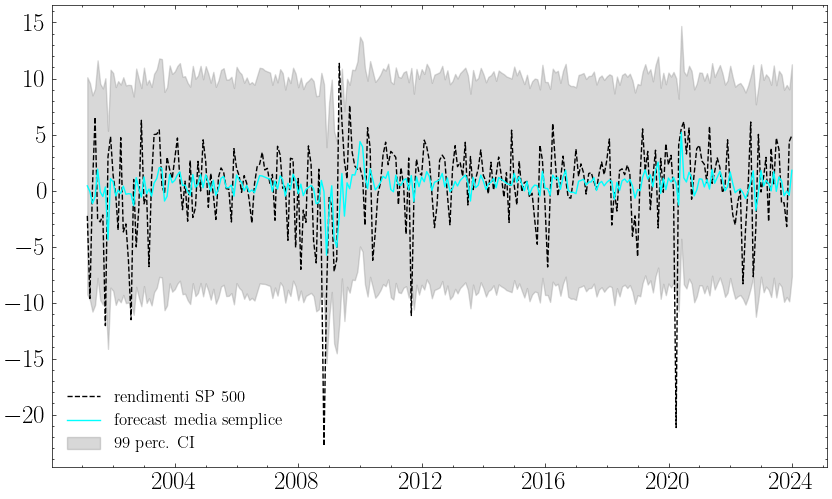

In [82]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_ensemble_learning_simple_mean_list, label='forecast media semplice', color='cyan')
    plt.fill_between(date_list, lower_bound_ensemble_learning_simple_mean_list, upper_bound_ensemble_learning_simple_mean_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_simple_mean_CI.svg', format='svg')

    plt.show()

## Forecast Weighted R2

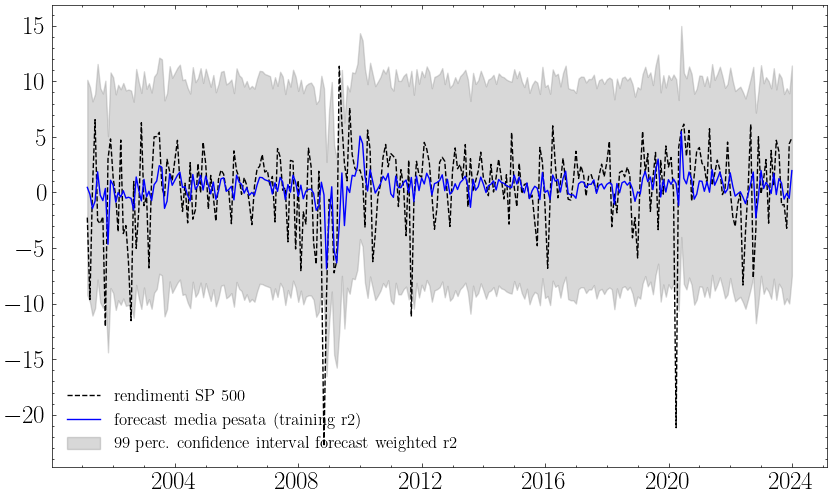

In [83]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_ensemble_learning_weighted_r2_list, label='forecast media pesata (training r2)', color='blue')
    plt.fill_between(date_list, lower_bound_ensemble_learning_weighted_r2_list, upper_bound_ensemble_learning_weighted_r2_list, color='gray', alpha=0.3, label='99 perc. confidence interval forecast weighted r2')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')

    plt.savefig('plots/forecast_weighted_r2_CI.svg', format='svg')

    plt.show()

## Forecast weighted RMSE

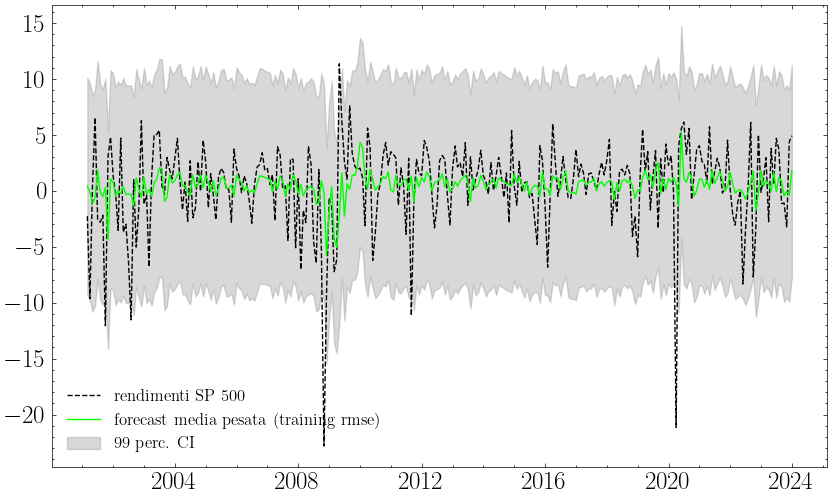

In [84]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_ensemble_learning_weighted_rmse_list, label='forecast media pesata (training rmse)', color='lime')
    plt.fill_between(date_list, lower_bound_ensemble_learning_weighted_rmse_list, upper_bound_ensemble_learning_weighted_rmse_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_weighted_rmse_CI.svg', format='svg')

    plt.show()

## Forecast weighted test RMSE

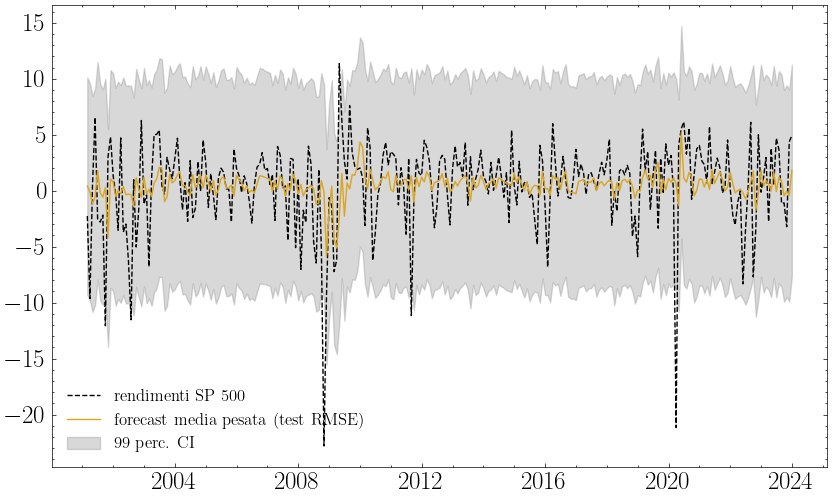

In [85]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_ensemble_learning_weighted_test_rmse_list, label='forecast media pesata (test RMSE)', color='goldenrod')
    plt.fill_between(date_list, lower_bound_ensemble_learning_weighted_test_rmse_list, upper_bound_ensemble_learning_weighted_test_rmse_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_weighted_test_rmse_CI.svg', format='svg')

    plt.show()

## Forecast BIC monthly best

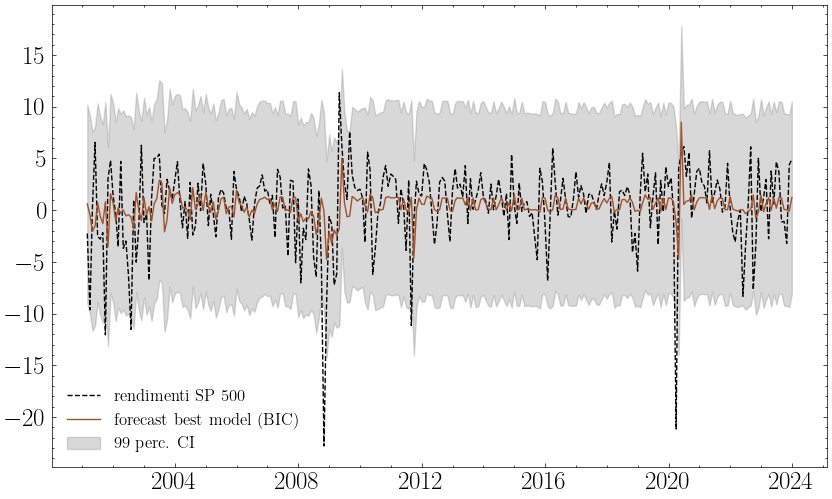

In [86]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_bic_monthly_best_list, label='forecast best model (BIC)', color='sienna')
    plt.fill_between(date_list, lower_bound_bic_monthly_best_list, upper_bound_bic_monthly_best_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_BIC_monthly_best_CI.svg', format='svg')

    plt.show()

## Forecast AIC Monthly best

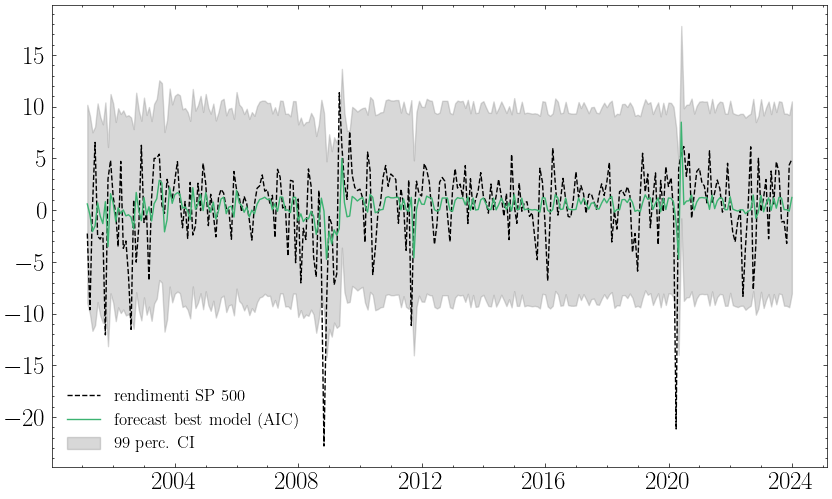

In [87]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_aic_monthly_best_list, label='forecast best model (AIC)', color='mediumseagreen')
    plt.fill_between(date_list, lower_bound_aic_monthly_best_list, upper_bound_aic_monthly_best_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_AIC_monthly_best_CI.svg', format='svg')

    plt.show()

## Combined Forecast (BIC)

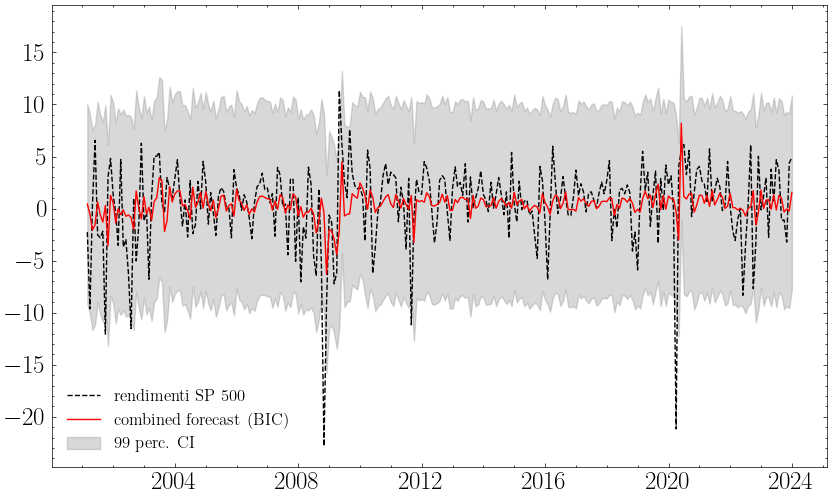

In [88]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_bic_monthly_weighted_average_list, label='combined forecast (BIC)', color='red')
    plt.fill_between(date_list,lower_bound_bic_weighted_average_list , upper_bound_bic_weighted_average_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_BIC_weighted_average_CI.svg', format='svg')

    plt.show()

## Combined Forecast (BIC) Converted

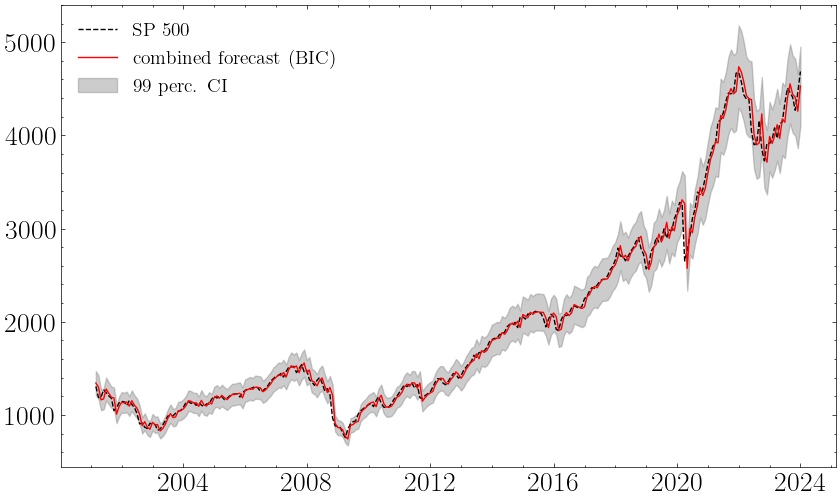

In [89]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, sp_500_true_list, label='SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_bic_monthly_weighted_average_converted_list, label='combined forecast (BIC)', color='red')
    plt.fill_between(date_list,lower_bound_bic_weighted_average_converted_list , upper_bound_bic_weighted_average_converted_list, color='gray', alpha=0.4, label='99 perc. CI')

        
    plt.xticks(fontsize=20)  
    plt.yticks(fontsize=20)
    plt.grid(False)
    plt.legend(fontsize=14, loc='upper left')
    plt.savefig('plots/forecast_BIC_weighted_average_converted_CI.svg', format='svg')

    plt.show()

In [90]:
len(date_list), len(lower_bound_bic_weighted_average_converted_list), len(upper_bound_bic_weighted_average_converted_list)

(275, 275, 275)

In [91]:
date_list

[Timestamp('2001-02-28 00:00:00'),
 Timestamp('2001-03-31 00:00:00'),
 Timestamp('2001-04-30 00:00:00'),
 Timestamp('2001-05-31 00:00:00'),
 Timestamp('2001-06-30 00:00:00'),
 Timestamp('2001-07-31 00:00:00'),
 Timestamp('2001-08-31 00:00:00'),
 Timestamp('2001-09-30 00:00:00'),
 Timestamp('2001-10-31 00:00:00'),
 Timestamp('2001-11-30 00:00:00'),
 Timestamp('2001-12-31 00:00:00'),
 Timestamp('2002-01-31 00:00:00'),
 Timestamp('2002-02-28 00:00:00'),
 Timestamp('2002-03-31 00:00:00'),
 Timestamp('2002-04-30 00:00:00'),
 Timestamp('2002-05-31 00:00:00'),
 Timestamp('2002-06-30 00:00:00'),
 Timestamp('2002-07-31 00:00:00'),
 Timestamp('2002-08-31 00:00:00'),
 Timestamp('2002-09-30 00:00:00'),
 Timestamp('2002-10-31 00:00:00'),
 Timestamp('2002-11-30 00:00:00'),
 Timestamp('2002-12-31 00:00:00'),
 Timestamp('2003-01-31 00:00:00'),
 Timestamp('2003-02-28 00:00:00'),
 Timestamp('2003-03-31 00:00:00'),
 Timestamp('2003-04-30 00:00:00'),
 Timestamp('2003-05-31 00:00:00'),
 Timestamp('2003-06-

In [92]:
lower_bound_bic_weighted_average_converted_list

[1212.6869704666296,
 1174.2587427432718,
 1050.082983759614,
 1059.3379932580042,
 1155.5147571205102,
 1113.341324874051,
 1074.736441222893,
 1068.4736852641258,
 910.9257642425007,
 985.1827896521746,
 1026.3889425365724,
 1020.3602781583581,
 1030.1868441980084,
 988.8792049231515,
 1041.3387547138616,
 997.3566992218184,
 969.3182931022526,
 908.5206037347978,
 800.1343591172825,
 838.490392584449,
 784.2599736126706,
 764.4915082090272,
 831.3549547523751,
 808.1308475683977,
 810.3557766443612,
 747.6686152520592,
 769.9058099531823,
 812.4146930308741,
 870.9729337874571,
 916.6415157956105,
 877.2003346956261,
 883.7479553555738,
 941.3653177909176,
 945.150582896971,
 962.7347290197625,
 993.8282222109808,
 1041.7406858001548,
 1036.6772533663689,
 1020.3757785823512,
 1022.7343696091422,
 987.3369183277114,
 1045.723863324416,
 1001.3660647060399,
 991.0521819187948,
 1026.675153787037,
 1010.7664403186282,
 1074.81761399021,
 1089.1694267560329,
 1066.4570762647315,
 1094.

In [93]:
upper_bound_bic_weighted_average_converted_list

[1470.1031982883733,
 1423.4494548258872,
 1273.0105328386646,
 1284.1588234868327,
 1401.3823180164059,
 1349.8803668339772,
 1302.9981027982335,
 1295.6063611357836,
 1105.2630075732302,
 1195.4527531544059,
 1245.4273516837147,
 1238.0152676388175,
 1249.8437829800039,
 1199.7006295060942,
 1263.4002515817094,
 1210.0193457730393,
 1175.9370669070631,
 1102.2545975771948,
 971.1924734138423,
 1017.705829673761,
 951.9927647763429,
 927.932365773469,
 1009.2535420119987,
 981.0057789708721,
 983.6278817087987,
 907.6615966202971,
 934.6040392252081,
 986.217986643117,
 1057.3006341812777,
 1112.6930127947624,
 1064.752567824326,
 1072.633118493065,
 1140.9892657385062,
 1145.491863740059,
 1166.7304888385984,
 1204.3395470526473,
 1262.3810590050214,
 1256.1515679636755,
 1236.325264403342,
 1239.0871506316084,
 1196.1387918979935,
 1266.8062110895653,
 1213.082806702838,
 1200.5113999830028,
 1243.5979081993794,
 1224.249237857146,
 1301.8505602263692,
 1319.1340176636586,
 1291.551

In [94]:
print(np.isnan(lower_bound_bic_weighted_average_converted_list).any())
print(np.isnan(upper_bound_bic_weighted_average_converted_list).any())


False
False


## Combined Forecast (AIC)

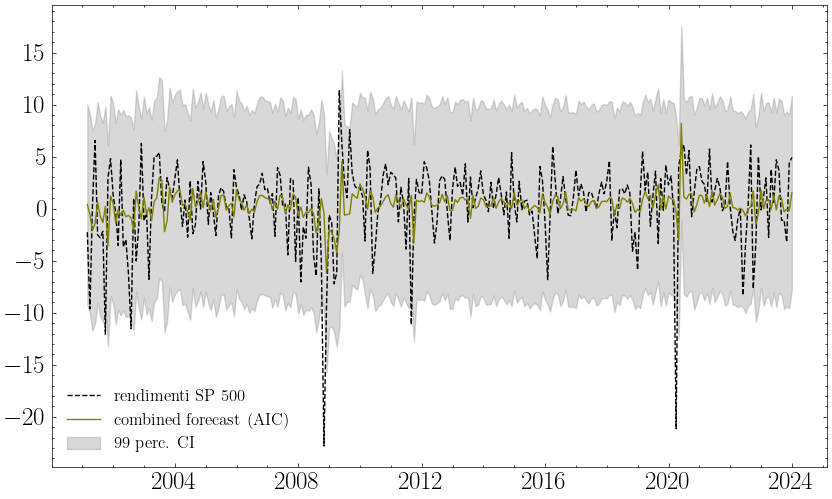

In [95]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    # Grafico del rendimento reale
    plt.plot(date_list, y_true_list, label='rendimenti SP 500', color='black', linestyle='--')

    # Grafico del forecast ECM
    plt.plot(date_list, forecast_aic_monthly_weighted_average_list, label='combined forecast (AIC)', color='olive')
    plt.fill_between(date_list,lower_bound_aic_weighted_average_list , upper_bound_aic_weighted_average_list, color='gray', alpha=0.3, label='99 perc. CI')

        
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.legend(fontsize=12, loc='lower left')
    plt.savefig('plots/forecast_AIC_weighted_average_CI.svg', format='svg')

    plt.show()

## P-Values ADF TEST

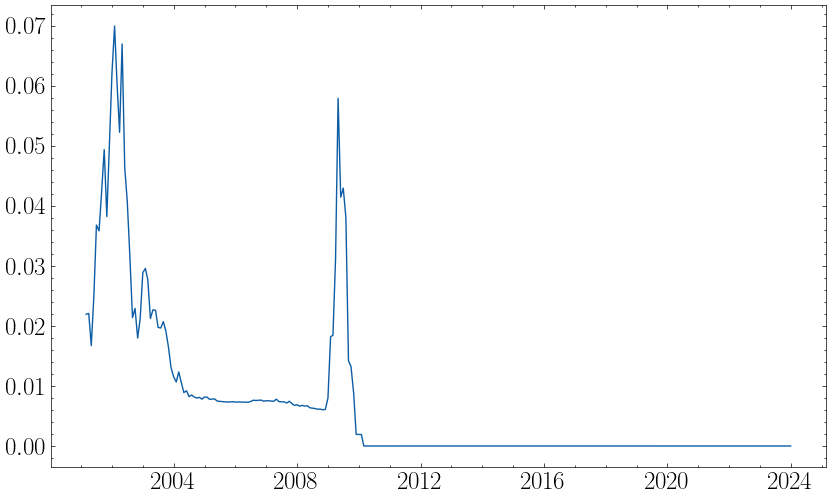

In [96]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    plt.plot(date_list, adf_output_list, label='ADF Test for residuals_Step1')
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    #plt.savefig('grafici/ADF_Test_for_residuals_Step1.svg', format='svg')

    plt.show()

## Coefficients of eps(t-1)

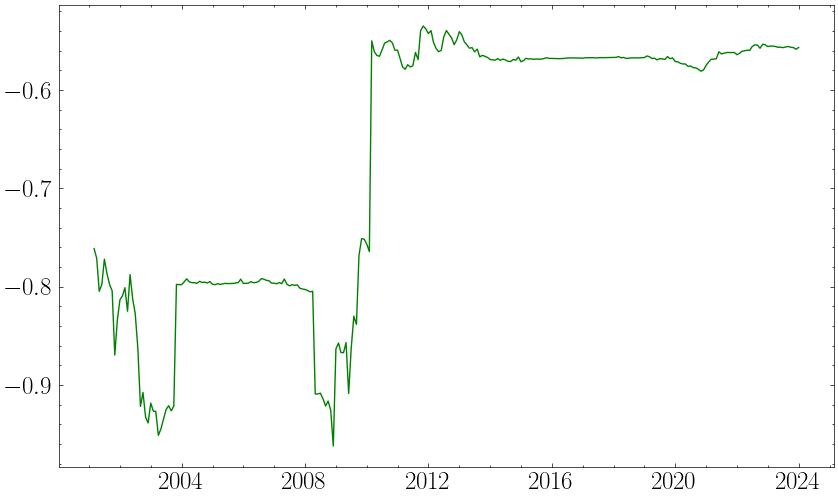

In [97]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    plt.plot(date_list, coefficients_of_eps_t_1__step2_list, label='Coefficients of eps(t-1)', color='green')
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    #plt.savefig('grafici/Coefficients_of_eps(t-1).svg', format='svg')

    plt.show()

## Rsquared_Step2

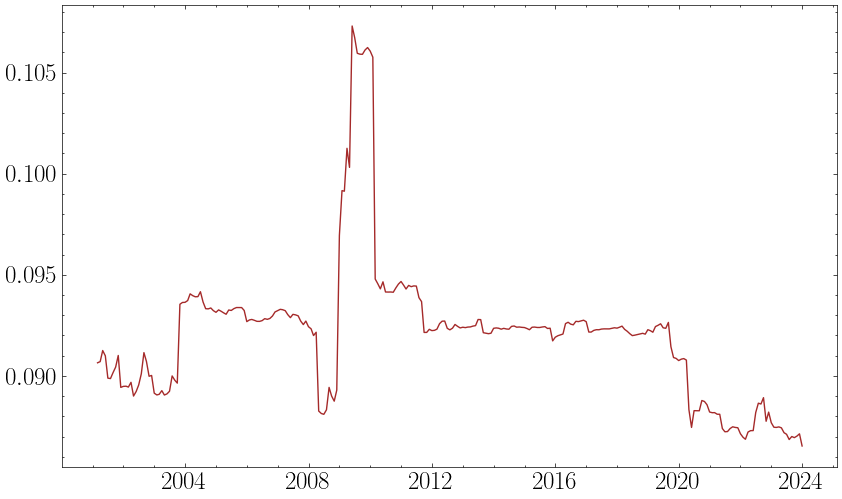

In [98]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    plt.plot(date_list, rsquared_step2_list, label='Rsquared Step2', color='brown')
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    #plt.savefig('grafici/Rsquared_Step2.svg', format='svg')

    plt.show()

In [99]:
all_models_forecast_over_time_df.head()

observed_sp500_returns  forecast_randomwalk  \
2001-02-28               -2.262550             4.105133   
2001-03-31               -9.631777            -0.117433   
2001-04-30                0.335903            -7.482740   
2001-05-31                6.548935             2.484055   
2001-06-30               -2.523768             8.697970   

            forecast_engle_granger  lower_bound_engle_granger  \
2001-02-28                0.133504                  -9.483878   
2001-03-31               -0.665220                 -10.279871   
2001-04-30               -2.184651                 -11.813943   
2001-05-31               -1.219197                 -10.845896   
2001-06-30                0.490032                  -9.146447   

            upper_bound_engle_granger  forecast_rf  lower_bound_rf  \
2001-02-28                   9.750887     0.115026       -9.601724   
2001-03-31                   8.949431     0.066192       -9.647695   
2001-04-30                   7.444641    -0.309400      -10.039042   
2001-05-31                   8.407501    -0.001654       -9.727712   
2001-06-30                  10.126511     1.175698       -8.556591   

            upper_bound_rf  forecast_svr  lower_bound_svr  ...  \
2001-02-28        9.831776      0.820825        -9.025113  ...   
2001-03-31        9.780078      0.686346        -9.157843  ...   
2001-04-30        9.420242     -0.055681        -9.701121  ...   
2001-05-31        9.724405      0.502310        -9.139052  ...   
2001-06-30       10.907987      5.251115        -4.613773  ...   

            upper_bound_bic_weighted_average  \
2001-02-28                         10.025803   
2001-03-31                          9.063196   
2001-04-30                          7.525422   
2001-05-31                          8.061207   
2001-06-30                         10.249763   

            forecast_aic_monthly_weighted_average  \
2001-02-28                               0.402226   
2001-03-31                              -0.542582   
2001-04-30                              -2.107615   
2001-05-31                              -1.431459   
2001-06-30                               0.619830   

            lower_bound_aic_monthly_weighted_average  \
2001-02-28                                 -9.195004   
2001-03-31                                -10.137408   
2001-04-30                                -11.714496   
2001-05-31                                -11.035569   
2001-06-30                                 -8.998044   

            upper_bound_aic_monthly_weighted_average  \
2001-02-28                                  9.999455   
2001-03-31                                  9.052244   
2001-04-30                                  7.499267   
2001-05-31                                  8.172652   
2001-06-30                                 10.237705   

            forecast_bic_monthly_weighted_average_converted  \
2001-02-28                                      1341.395084   
2001-03-31                                      1298.854099   
2001-04-30                                      1161.546758   
2001-05-31                                      1171.748408   
2001-06-30                                      1278.448538   

            lower_bound_bic_weighted_average_converted  \
2001-02-28                                 1212.686970   
2001-03-31                                 1174.258743   
2001-04-30                                 1050.082984   
2001-05-31                                 1059.337993   
2001-06-30                                 1155.514757   

            upper_bound_bic_weighted_average_converted  adf_output  \
2001-02-28                                 1470.103198    0.021938   
2001-03-31                                 1423.449455    0.022087   
2001-04-30                                 1273.010533    0.016722   
2001-05-31                                 1284.158823    0.025052   
2001-06-30                                 1401.382318    0.036786   

            rsqua

In [100]:
def binarize_returns(returns):
    
    binarized_returns_list = []
    
    for value in returns:
        
        if value >= 0:
            
            value = 1
            
        else:
            
            value = 0
            
        binarized_returns_list.append(value)
        
    returns = pd.Series(binarized_returns_list, index=returns.index)
    
            
    return returns       

In [101]:
# Binarized Dataframe creation
for colonna in all_models_forecast_over_time_df.columns:
    
    if colonna == "observed_sp500_returns":
        binarized_observed_sp500_returns = binarize_returns(all_models_forecast_over_time_df[colonna])
        df_binarized = pd.DataFrame(index=all_models_forecast_over_time_df.index)
        df_binarized[colonna] = binarized_observed_sp500_returns
    
    elif colonna.startswith("forecast_"):
        binarized_forecast = binarize_returns(all_models_forecast_over_time_df[colonna])
        df_binarized[colonna] = binarized_forecast
  
df_binarized.head(10)  
    

observed_sp500_returns  forecast_randomwalk  \
2001-02-28                       0                    1   
2001-03-31                       0                    0   
2001-04-30                       1                    0   
2001-05-31                       1                    1   
2001-06-30                       0                    1   
2001-07-31                       0                    0   
2001-08-31                       0                    0   
2001-09-30                       0                    0   
2001-10-31                       1                    0   
2001-11-30                       1                    1   

            forecast_engle_granger  forecast_rf  forecast_svr  forecast_ann  \
2001-02-28                       1            1             1             1   
2001-03-31                       0            1             1             0   
2001-04-30                       0            0             0             0   
2001-05-31                       0            0             1             0   
2001-06-30                       1            1             1             1   
2001-07-31                       0            0             1             0   
2001-08-31                       0            0             1             0   
2001-09-30                       0            0             1             1   
2001-10-31                       0            0             0             0   
2001-11-30                       1            1             1             1   

            forecast_ensemble_learning_simple_mean  \
2001-02-28                                       1   
2001-03-31                                       0   
2001-04-30                                       0   
2001-05-31                                       0   
2001-06-30                                       1   
2001-07-31                                       0   
2001-08-31                                       0   
2001-09-30                                       1   
2001-10-31                                       0   
2001-11-30                                       1   

            forecast_ensemble_learning_weighted_r2  \
2001-02-28                                       1   
2001-03-31                                       0   
2001-04-30                                       0   
2001-05-31                                       0   
2001-06-30                                       1   
2001-07-31                                       0   
2001-08-31                                       0   
2001-09-30                                       1   
2001-10-31                                       0   
2001-11-30                                       1   

            forecast_ensemble_learning_weighted_rmse  \
2001-02-28                                         1   
2001-03-31                                         0   
2001-04-30                                         0   
2001-05-31                                         0   
2001-06-30                                         1   
2001-07-31                                         0   
2001-08-31                                         0   
2001-09-30                                         1   
2001-10-31                                         0   
2001-11-30                                         1   

            forecast_ensemble_learning_weighted_test_rmse  \
2001-02-28                                              1   
2001-03-31                                              0   
2001-04-30                                              0   
2001-05-31                                              0   
2001-06-30                                              1   
2001-07-31                                              0   
2001-08-31                                              0   
2001-09-30                                              1   
2001-10-31                                              0   
2001-11-30                                              1   

            f

In [102]:
# Creating hit ratio dataframe
hit_ratio_df = pd.DataFrame(columns = ["hit_ratio_percent"] , index = df_binarized.columns[1:])

for column in df_binarized.columns:
    
    if column == "observed_sp500_returns":
        continue
    
    comparison = df_binarized[column] == df_binarized["observed_sp500_returns"]
    num_hit_ratio = 0
    
    for value in comparison:
        if value == True:
            num_hit_ratio += 1
            
    hit_ratio = num_hit_ratio / len(comparison) * 100
    hit_ratio_df.loc[column] = hit_ratio
    
    
hit_ratio_df

hit_ratio_percent
forecast_randomwalk                                          64.0
forecast_engle_granger                                  61.818182
forecast_rf                                             62.909091
forecast_svr                                            62.909091
forecast_ann                                            60.727273
forecast_ensemble_learning_simple_mean                  62.545455
forecast_ensemble_learning_weighted_r2                  62.181818
forecast_ensemble_learning_weighted_rmse                62.181818
forecast_ensemble_learning_weighted_test_rmse           62.181818
forecast_bic_monthly_best                               62.909091
forecast_aic_monthly_best                               62.909091
forecast_bic_monthly_weighted_average                   62.181818
forecast_aic_monthly_weighted_average                   62.181818
forecast_bic_monthly_weighted_average_converted         63.636364